# Final Project: Regression Analysis

## Name: Gabriel Richards

## Date: 12 Apr 2025

## Overview
In this report we have reviewed the UC Irvide data set covering Automobile MPG. We create a new feature from the car name, and use it alongside vehicle weight and model year to feed a linear regression model and predict mpg.



## Dataset 
Auto MPG Dataset (Predict fuel efficiency based on engine specs and weight)
   - [UCI Auto MPG Dataset](https://archive-beta.ics.uci.edu/ml/datasets/auto+mpg)

## Section 1. Import and Inspect the Data


### 1.0 Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import ks_2samp, wasserstein_distance, energy_distance

import math
import time

# using this variable allows us to change all of the random_state variables throughout the document at once
# this can help us compare behavior of our methodology across seeds
state_setter=747

We use pandas and numpy for data frame manipulation and calculations, matplotlib and seaborn are used to generate graphs, numpy and scipy were used for statistical calculations, and sklearn was used for model training and evaluation.

### 1.1 Load the dataset and display the first 10 rows.


I used utils/convert_to_csv.py to convert our original auto-mpg.data file to a csv for easy consumption by Pandas. Pandas also had trouble with the data set due to some corrupted values, so convert_to_csv converts any mismatched values in auto-mpg.data to blanks when generating auto-mpg.csv.

In [2]:
# Load the dataset
df = pd.read_csv('data/auto-mpg.csv')

# Display the first 10 rows
print("First 10 rows of the dataset:")
display(df.head(10))

First 10 rows of the dataset:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
5,15.0,8,429.0,198.0,4341.0,10.0,70,1,ford galaxie 500
6,14.0,8,454.0,220.0,4354.0,9.0,70,1,chevrolet impala
7,14.0,8,440.0,215.0,4312.0,8.5,70,1,plymouth fury iii
8,14.0,8,455.0,225.0,4425.0,10.0,70,1,pontiac catalina
9,15.0,8,390.0,190.0,3850.0,8.5,70,1,amc ambassador dpl


### 1.2 Check for missing values and display summary statistics.



In [3]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())



Missing values in each column:
mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


Horsepower is missing 6 values. We will address this in section 2.

In [4]:
# Get summary statistics
pd.set_option('display.expand_frame_repr', False)

print("\nSummary statistics:")
print(df.describe(include='all').T)


Summary statistics:
              count unique         top freq         mean         std     min      25%     50%     75%     max
mpg           398.0    NaN         NaN  NaN    23.514573    7.815984     9.0     17.5    23.0    29.0    46.6
cylinders     398.0    NaN         NaN  NaN     5.454774    1.701004     3.0      4.0     4.0     8.0     8.0
displacement  398.0    NaN         NaN  NaN   193.425879  104.269838    68.0   104.25   148.5   262.0   455.0
horsepower    392.0    NaN         NaN  NaN   104.469388    38.49116    46.0     75.0    93.5   126.0   230.0
weight        398.0    NaN         NaN  NaN  2970.424623  846.841774  1613.0  2223.75  2803.5  3608.0  5140.0
acceleration  398.0    NaN         NaN  NaN     15.56809    2.757689     8.0   13.825    15.5  17.175    24.8
model_year    398.0    NaN         NaN  NaN     76.01005    3.697627    70.0     73.0    76.0    79.0    82.0
origin        398.0    NaN         NaN  NaN     1.572864    0.802055     1.0      1.0     1.0     2

Some summary statistics for the info. Note that unique, top, and freq are generated for categorical features whereas mean, std, and min are generated for numerical features.

In [5]:
# Check data types
print("\nData types:")
print(df.dtypes)

# Check unique values in categorical columns
print("\nUnique values in 'origin' column:")
print(df['origin'].unique())


Data types:
mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model_year        int64
origin            int64
car_name         object
dtype: object

Unique values in 'origin' column:
[1 3 2]


We have mostly numerical columns with a couple string columns.

### Reflection 1: What do you notice about the dataset? Are there any data issues?

The 'origin' column contains only integers (1, 2, and 3), but they probably represent categorical information about manufacturing locations that should be properly encoded. 


The dataset spans model years from the 1970s to early 1980s based on the 'model_year' column, making this a historical dataset that might not reflect current automotive technology. These issues will need to be resolved through appropriate data cleaning and transformation steps before proceeding with modeling. The engine is misfiring on this dataset, but with some fine-tuning, we'll have it purring in no time.

## Section 2. Data Exploration and Preparation


### 2.1 Handle missing values and clean data
First, let's examine our missing values more closely and create a plan to handle them. We already identified that the 'horsepower' column has 6 missing values, and they appear to be represented as '?' characters. Let's double check that all got taken care of with our earlier work.

In [6]:
# Function to check for mismatched data types in the dataframe
def check_data_type_mismatches(df):
    print("Checking for data type mismatches in each column...")
    
    # Dictionary to store results
    mismatches = {}
    
    # Check each column
    for column in df.columns:
        # Get the data type of the column
        dtype = df[column].dtype
        
        # Check for mismatches based on the data type
        if dtype == 'int64' or dtype == 'float64':
            # For numeric columns, check for non-numeric values
            non_numeric_count = 0
            non_numeric_indices = []
            
            for i, value in enumerate(df[column]):
                # Try to convert to float to see if it's numeric
                try:
                    float(value)
                except (ValueError, TypeError):
                    # If conversion fails, it's not numeric
                    non_numeric_count += 1
                    if non_numeric_count <= 5:  # Limit to first 5 examples
                        non_numeric_indices.append(i)
            
            if non_numeric_count > 0:
                mismatches[column] = {
                    'expected_type': dtype,
                    'mismatch_count': non_numeric_count,
                    'example_indices': non_numeric_indices
                }
    
    # Print results
    if mismatches:
        print("\nMismatched data types found:")
        for column, info in mismatches.items():
            print(f"\nColumn: {column}")
            print(f"Expected type: {info['expected_type']}")
            print(f"Mismatches found: {info['mismatch_count']}")
            
            # Print examples
            print("Examples of mismatched values:")
            for idx in info['example_indices']:
                print(f"  Row {idx}: '{df.loc[idx, column]}'")
    else:
        print("\nNo data type mismatches found!")
    
    return mismatches

# Run the function on our dataframe
mismatches = check_data_type_mismatches(df)

Checking for data type mismatches in each column...

No data type mismatches found!


Looks good to go.

#### 2.1.1 Impute or drop missing values
Now that we've properly identified the missing values, we'll impute them using the median value of the horsepower column. This is a reasonable approach for this small number (6 out of ~400) of missing values in a numerical feature.

In [7]:
# Create an imputer for the horsepower column
horsepower_imputer = SimpleImputer(strategy='median')

# Fit the imputer on the horsepower data and transform it
df['horsepower'] = horsepower_imputer.fit_transform(df[['horsepower']])

# Verify that missing values have been imputed
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64


Worked well!

#### 2.1.2 Remove or transform outliers
Let's identify potential outliers in our numerical columns using boxplots. This will help us determine if any data points are significantly outside the normal range and might need to be addressed.

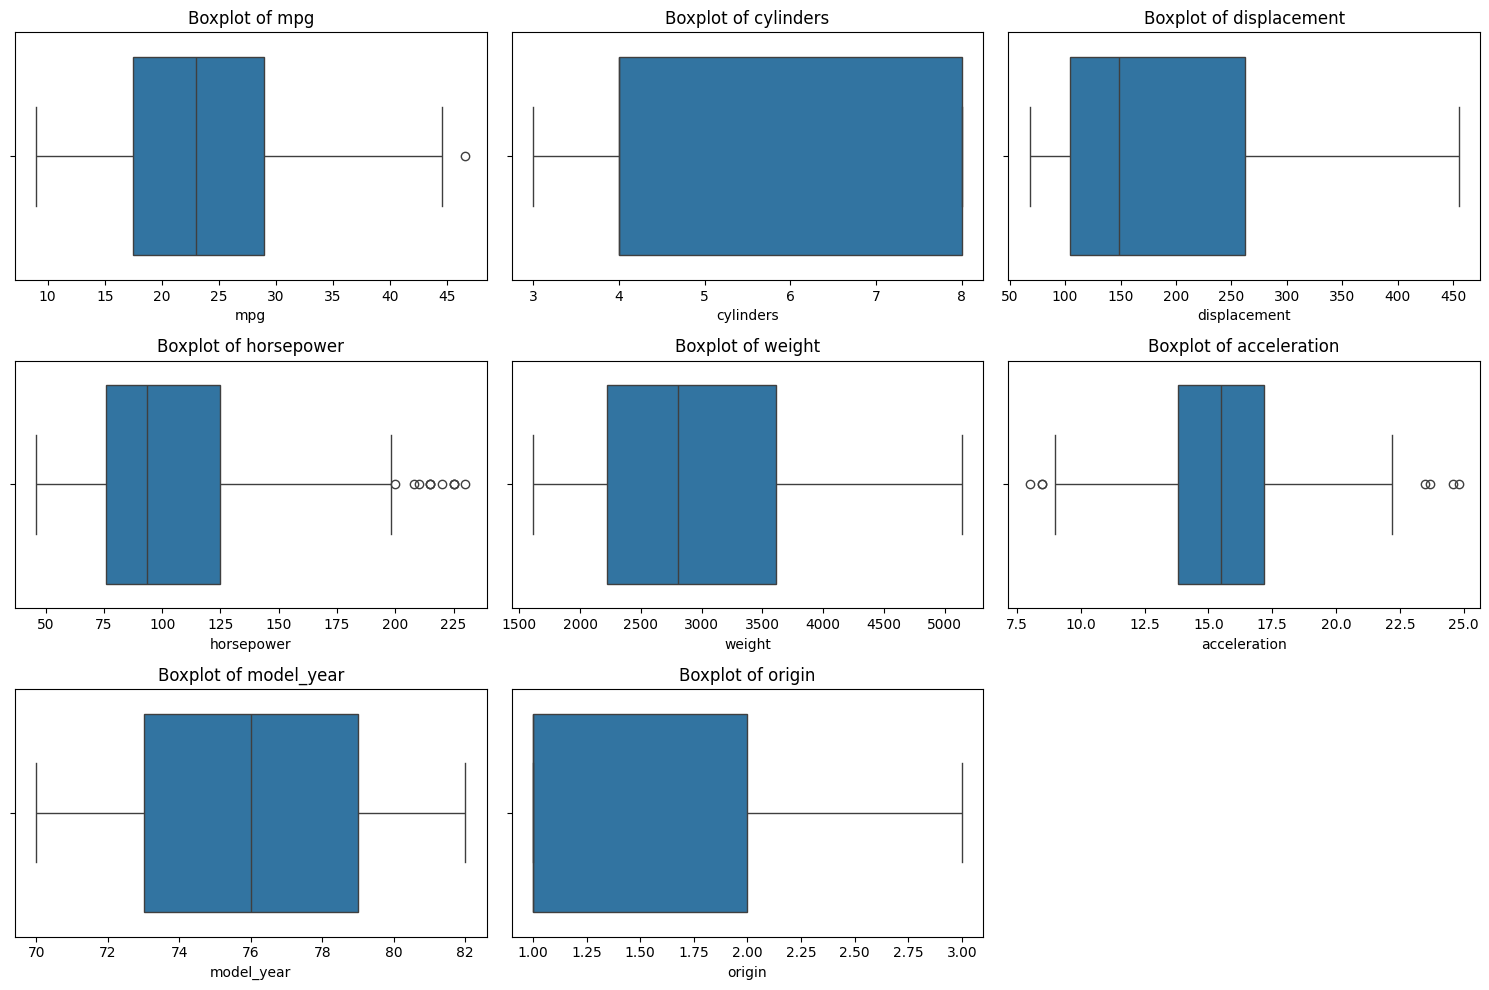

Column 'mpg' has 1 outliers
Column 'horsepower' has 11 outliers
Column 'acceleration' has 7 outliers


In [8]:
# Create boxplots for all numerical columns to identify outliers
plt.figure(figsize=(15, 10))

# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create boxplots for each numerical column
for i, column in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

# Calculate the IQR and identify outliers for each numerical column
for column in numerical_cols:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    if outliers > 0:
        print(f"Column '{column}' has {outliers} outliers")

The Boxplots show that some of the data has a wide range, but none of them are particularly plagued withoutliers. We shall proceed.

#### 2.1.3 Convert categorical data to numerical format using encoding
The 'origin' column is currently represented as integers (1, 2, 3) but it's actually a categorical feature representing the car's manufacturing region. 

By examining a few example rows, we can see that 1 is america, 2 is Europe, and 3 is Asia. I pulled open the csv separately and confirmed this by comparing models to where I know the manufacturer is based, but here are some example rows evidencing that:

| mpg | cylinders | displacement | horsepower | weight | acceleration | model_year | origin | car_name |
|-----|-----------|--------------|------------|--------|--------------|------------|--------|----------|
| 18.0 | 8 | 307.0 | 130.0 | 3504.0 | 12.0 | 70 | 1 | "chevrolet chevelle malibu" |
| 15.0 | 8 | 350.0 | 165.0 | 3693.0 | 11.5 | 70 | 1 | "buick skylark 320" |  
| 18.0 | 8 | 318.0 | 150.0 | 3436.0 | 11.0 | 70 | 1 | "plymouth satellite" |
| 26.0 | 4 | 97.00 | 46.00 | 1835.0 | 20.5 | 70 | 2 | "volkswagen 1131 deluxe sedan" |
| 25.0 | 4 | 110.0 | 87.00 | 2672.0 | 17.5 | 70 | 2 | "peugeot 504" |
| 24.0 | 4 | 107.0 | 90.00 | 2430.0 | 14.5 | 70 | 2 | "audi 100 ls" |
| 25.0 | 4 | 113.0 | 95.00 | 2228.0 | 14.0 | 71 | 3 | "toyota corona" |
| 27.0 | 4 | 97.00 | 88.00 | 2130.0 | 14.5 | 70 | 3 | "datsun pl510" |
| 35.0 | 4 | 72.00 | 69.00 | 1613.0 | 18.0 | 71 | 3 | "datsun 1200" |

Let's encode it properly using one-hot encoding.

In [9]:
# First, let's understand what the origin values represent
print("Value counts for 'origin':")
print(df['origin'].value_counts())

# Convert 'origin' to a more meaningful categorical representation
origin_mapping = {1: 'america', 2: 'europe', 3: 'asia'}
df['origin_name'] = df['origin'].map(origin_mapping)

# Apply one-hot encoding to the 'origin' column
origin_encoded = pd.get_dummies(df['origin_name'], prefix='origin')

# Join the encoded columns to the original dataframe
df = pd.concat([df, origin_encoded], axis=1)

# Drop the original 'origin' and 'origin_name' columns
df = df.drop(['origin', 'origin_name'], axis=1)

# Display the first few rows to confirm the encoding
print("\nFirst 5 rows after encoding 'origin':")
display(df.head())

Value counts for 'origin':
origin
1    249
3     79
2     70
Name: count, dtype: int64

First 5 rows after encoding 'origin':


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,origin_america,origin_asia,origin_europe
0,18.0,8,307.0,130.0,3504.0,12.0,70,chevrolet chevelle malibu,True,False,False
1,15.0,8,350.0,165.0,3693.0,11.5,70,buick skylark 320,True,False,False
2,18.0,8,318.0,150.0,3436.0,11.0,70,plymouth satellite,True,False,False
3,16.0,8,304.0,150.0,3433.0,12.0,70,amc rebel sst,True,False,False
4,17.0,8,302.0,140.0,3449.0,10.5,70,ford torino,True,False,False


### 2.2 Explore data patterns and distributions
Now let's visualize our dataset's key features to better understand their distributions and relationships, starting with histograms of our numerical features.

#### 2.2.1 Create histograms, boxplots, and count plots for categorical variables (as applicable).

Let's create visualizations to understand the distributions of our features. These plots will help us identify patterns and relationships in the data that might influence our modeling approach.

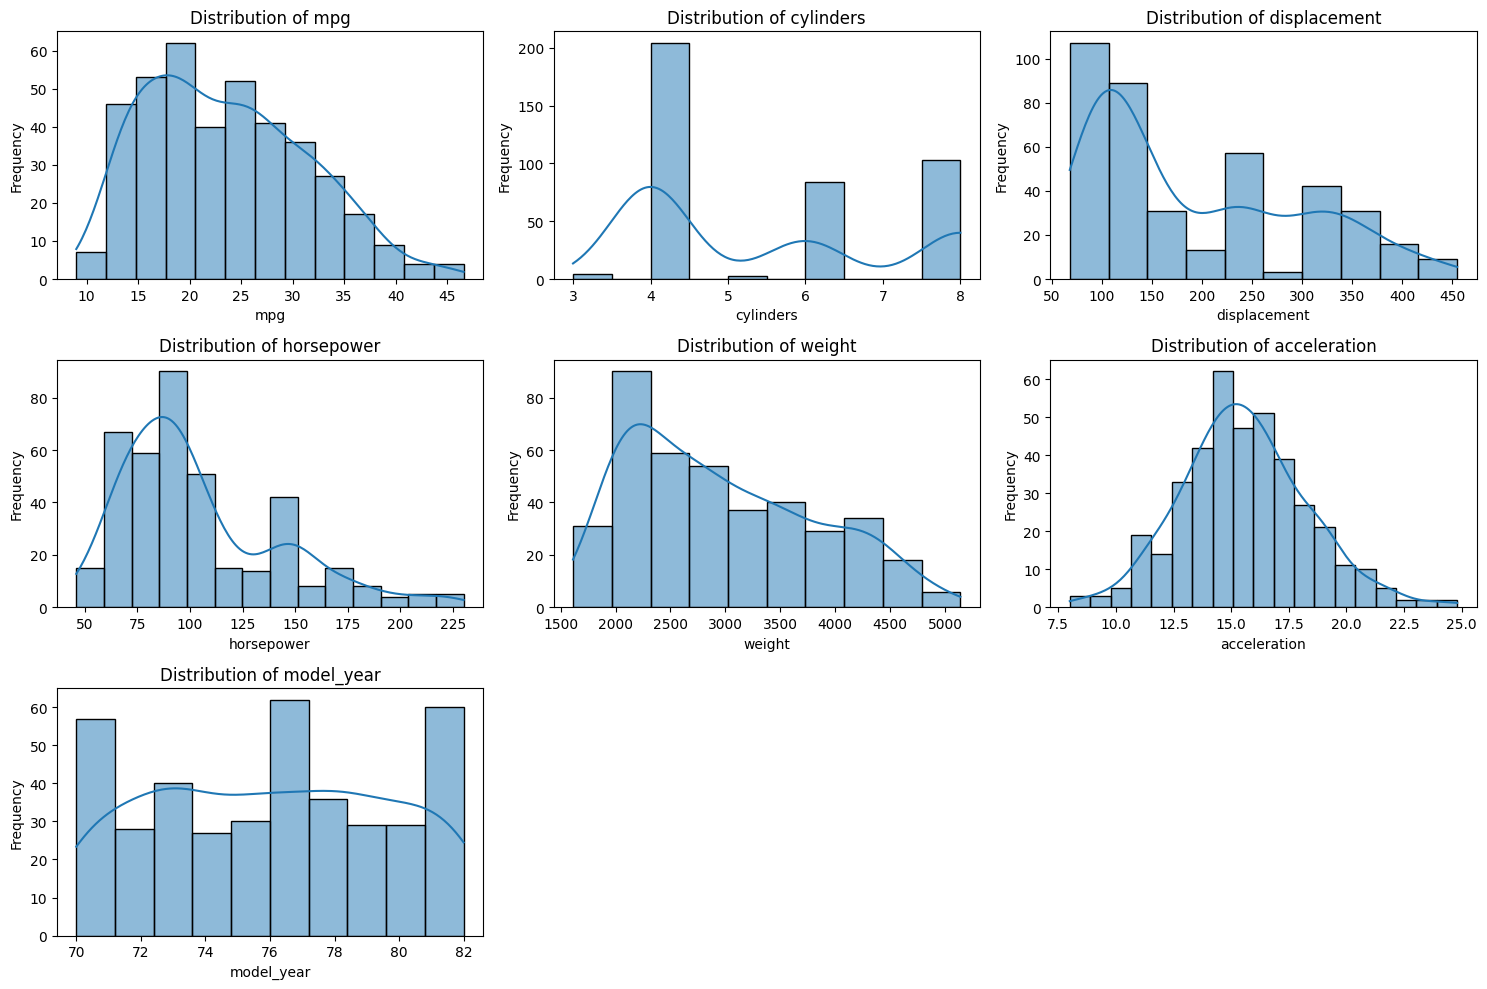

In [10]:
# Create histograms for numerical features
plt.figure(figsize=(15, 10))
numerical_features = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']

for i, feature in enumerate(numerical_features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()




Pretty reasonable distributions. 

It's generally distributed evenly across model years.

Horsepower has an interesting spike around 250hp.

The Cylinder distribution is the most interesting - there are a plurality of 4 cylinder samples, some 6 and 8 cylinder samples, and just a few oddball 3-5 cylinder vehicles.

Given we've established the origin to continent mapping, let's look closer at how the dataset is distributed across regions.

C:\Users\bob\AppData\Local\Temp\ipykernel_16584\2034928561.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, v - 15, f"{percentages[i]:.1f}%",


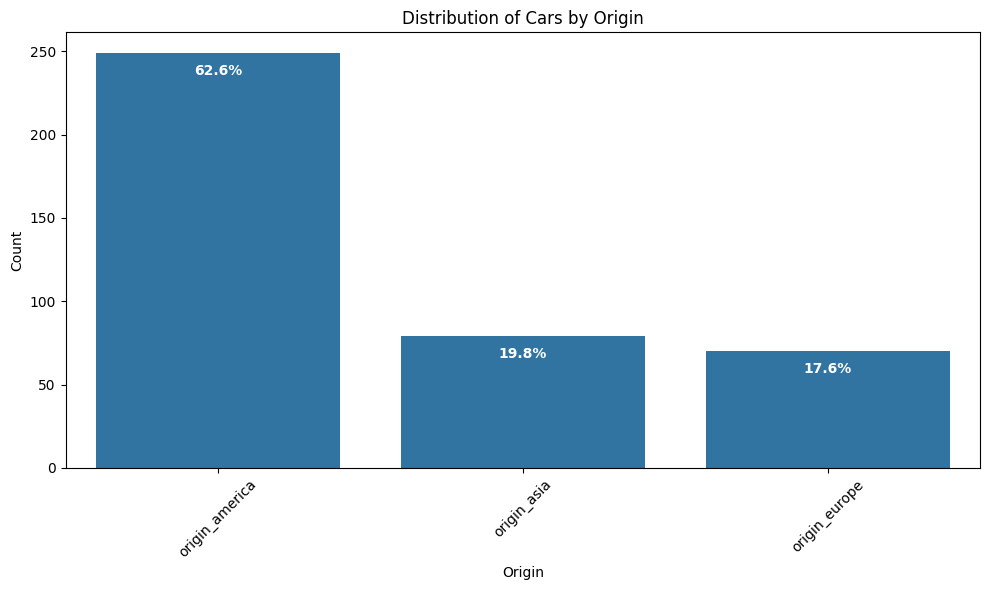

In [11]:
# Count plots for categorical variables (the encoded origin columns)
plt.figure(figsize=(10, 6))
origin_counts = df[['origin_america', 'origin_asia', 'origin_europe']].sum()
# Calculate percentages
total = origin_counts.sum()
percentages = (origin_counts / total) * 100

# Add percentage labels on top of each bar
for i, v in enumerate(origin_counts.values):
    plt.text(i, v - 15, f"{percentages[i]:.1f}%", 
             ha='center', va='bottom', color='white', fontweight='bold')
sns.barplot(x=origin_counts.index, y=origin_counts.values)
plt.title('Distribution of Cars by Origin')
plt.xlabel('Origin')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The dataset is a majority American, with a few dozen from the Asia and Europe regions as well.

#### 2.2.2 Identify patterns, outliers, and anomalies in feature distributions.

Now, let's examine relationships between features and identify potential outliers. Pulling up the correlation matrix and scatter plots will help us understand how features relate to our target variable (mpg) and to each other.

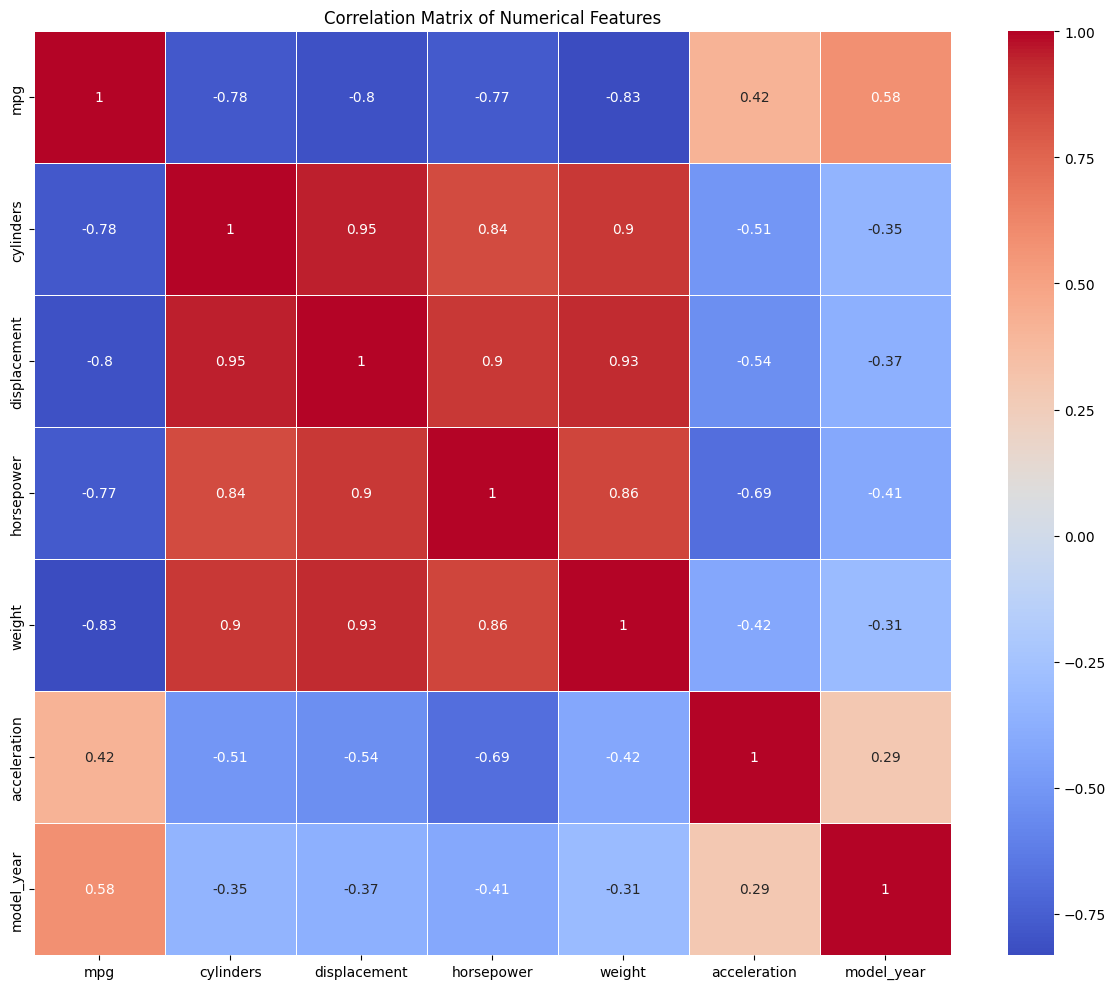

In [12]:
# Correlation matrix to identify relationships between numerical features
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

For numerical values, we are most focused on the left column. Given how weight, horsepower, displacement, and cylinder are both all closely associated with mpg with their high scores...but unfortunately they are all closely associated to one another. We will pick weight as our variable, given that it has the highest absolute correlation with mpg.

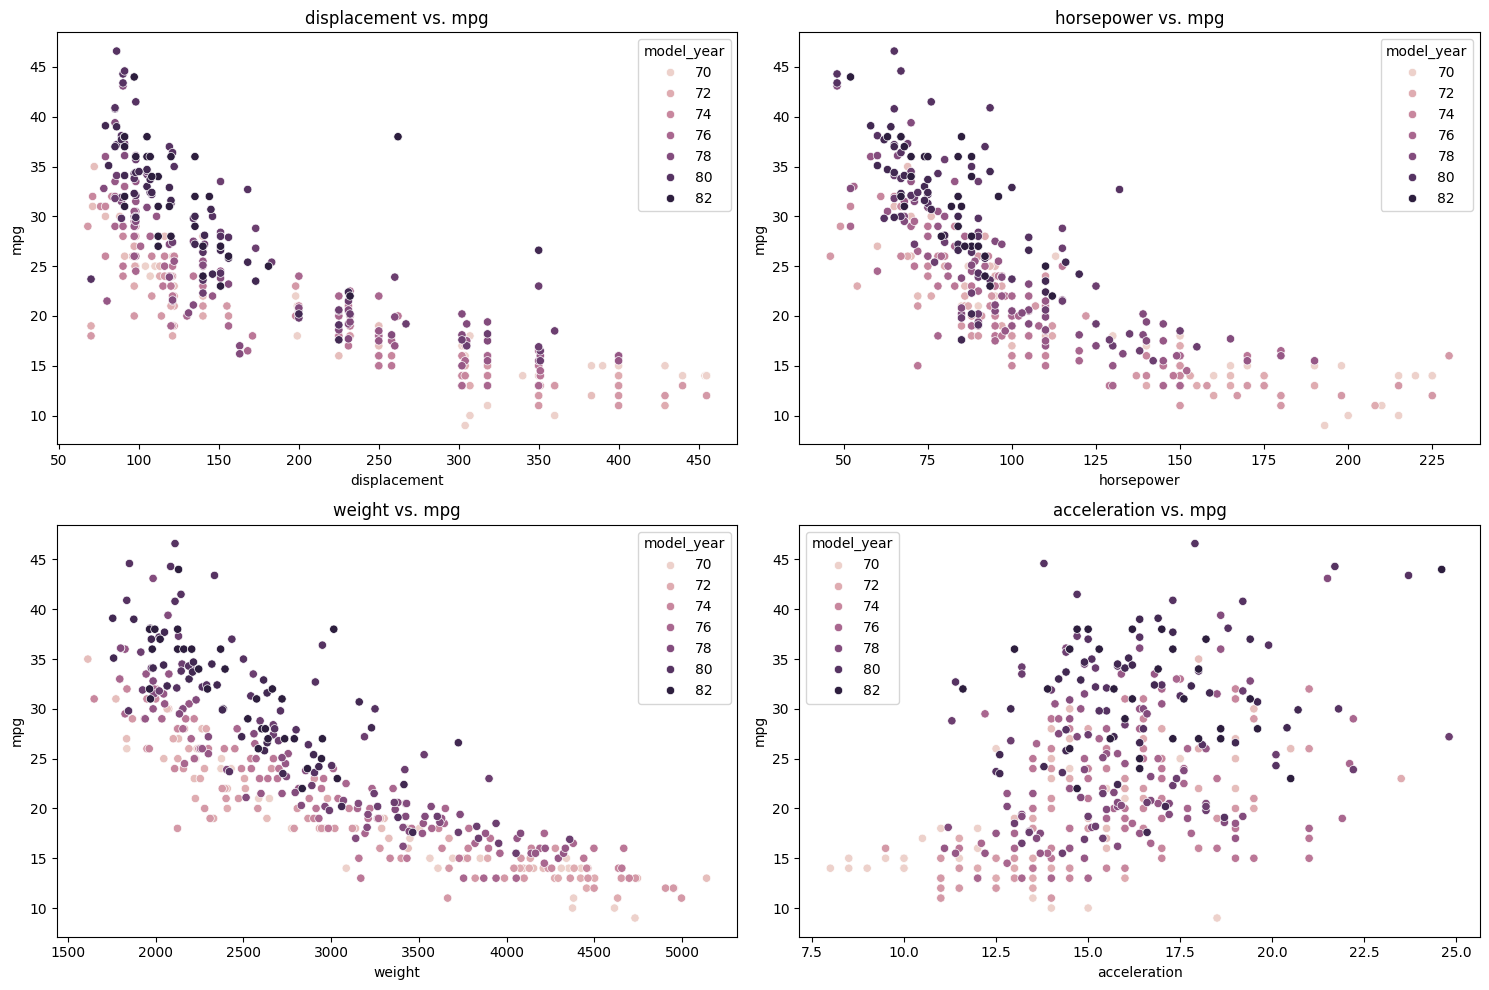

In [13]:
# Scatter plots of important features vs. target variable (mpg)
plt.figure(figsize=(15, 10))
features_to_plot = ['displacement', 'horsepower', 'weight', 'acceleration']

for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df[feature], y=df['mpg'], hue=df['model_year'])
    plt.title(f'{feature} vs. mpg')
    plt.xlabel(feature)
    plt.ylabel('mpg')

plt.tight_layout()
plt.show()

Reviewing displacement, weight, and horsepower, we can see the scatter plots are all quite similar.

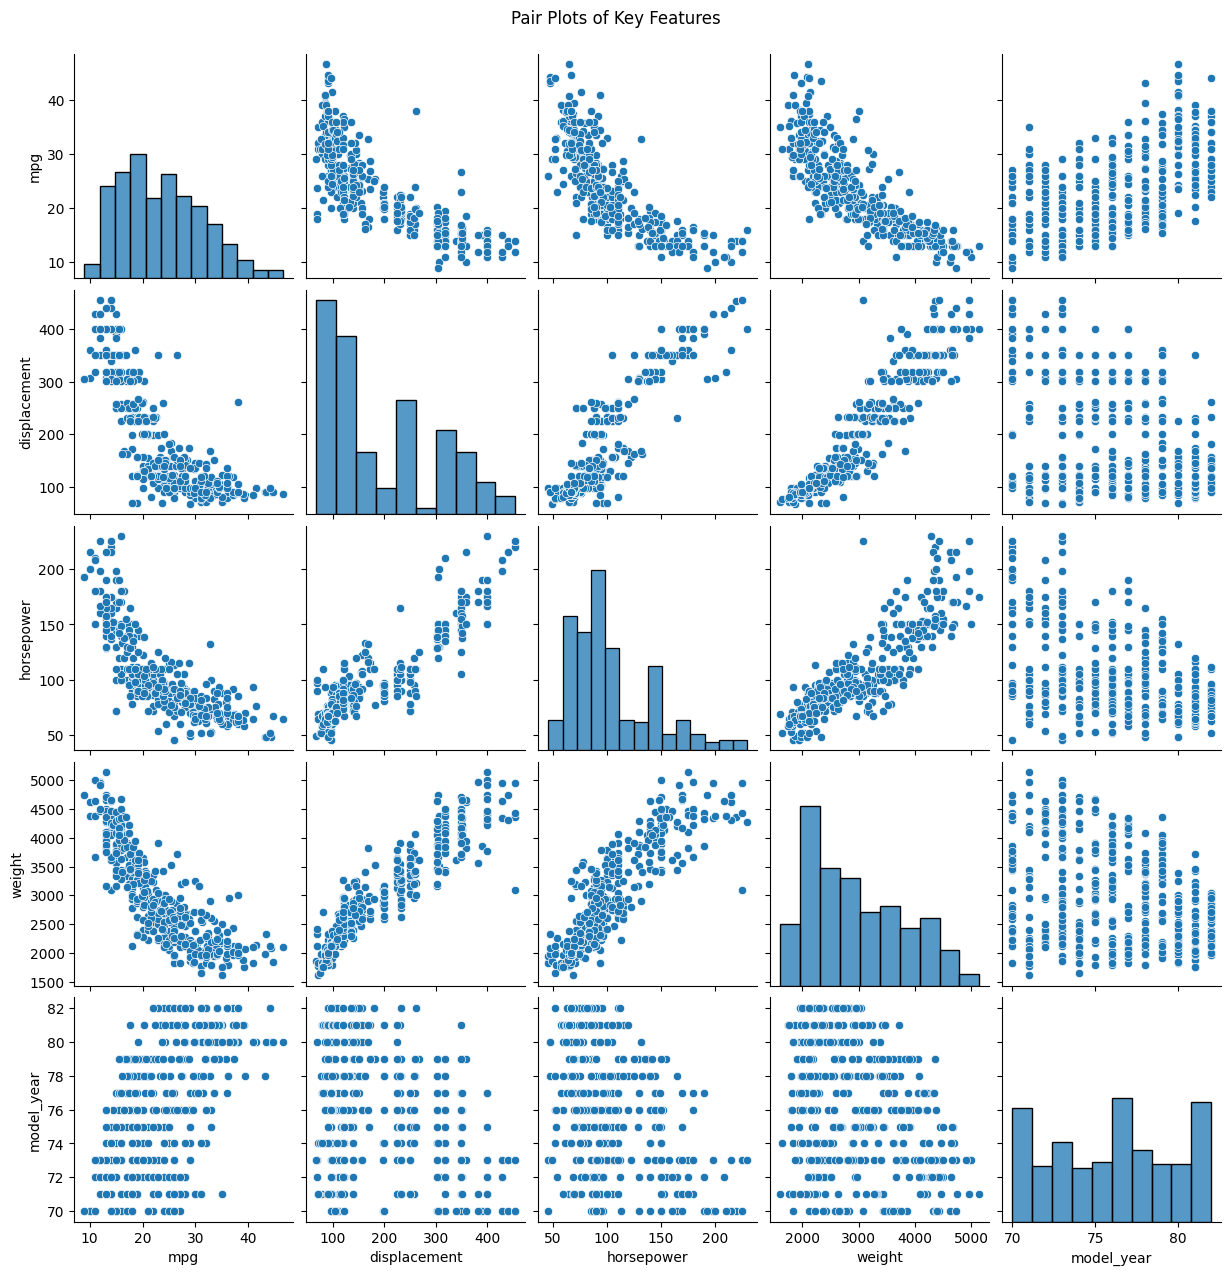

In [14]:
# Pair plots for key features to identify patterns and outliers
sns.pairplot(df[['mpg', 'displacement', 'horsepower', 'weight', 'model_year']])
plt.suptitle('Pair Plots of Key Features', y=1.02)
plt.show()

#### 2.2.3 Check for class imbalance in the target variable (as applicable).

While our target variable (mpg) is continuous for regression, we'll examine its distribution to ensure it's well-represented across its range and doesn't have concentrated values that could bias our model.

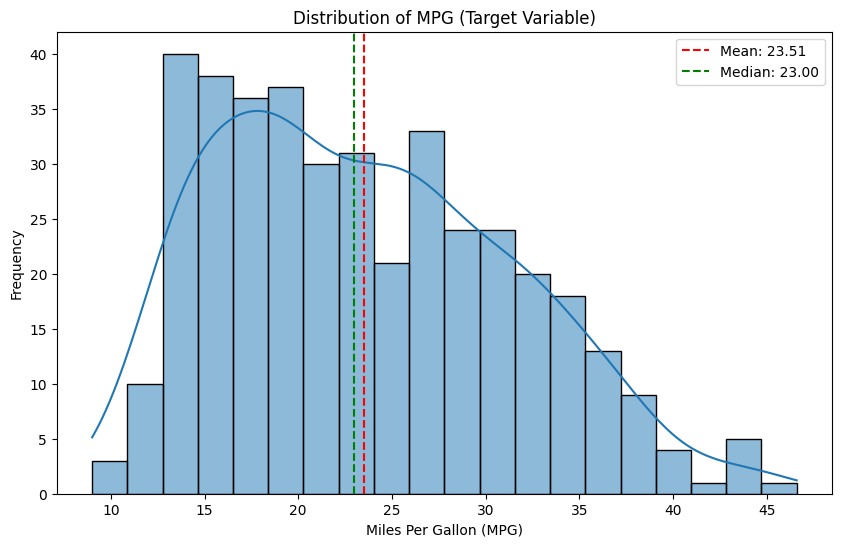

In [15]:
# Examine the distribution of the target variable (mpg)
plt.figure(figsize=(10, 6))
sns.histplot(df['mpg'], bins=20, kde=True)
plt.title('Distribution of MPG (Target Variable)')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Frequency')
plt.axvline(df['mpg'].mean(), color='red', linestyle='--', label=f'Mean: {df["mpg"].mean():.2f}')
plt.axvline(df['mpg'].median(), color='green', linestyle='--', label=f'Median: {df["mpg"].median():.2f}')
plt.legend()
plt.show()

An interesting distribution. Leans left a bit, but has some strength on the far right which pulls the mean right.

Let's investigate whether there's a connection between mpg and the origin region we established previously.

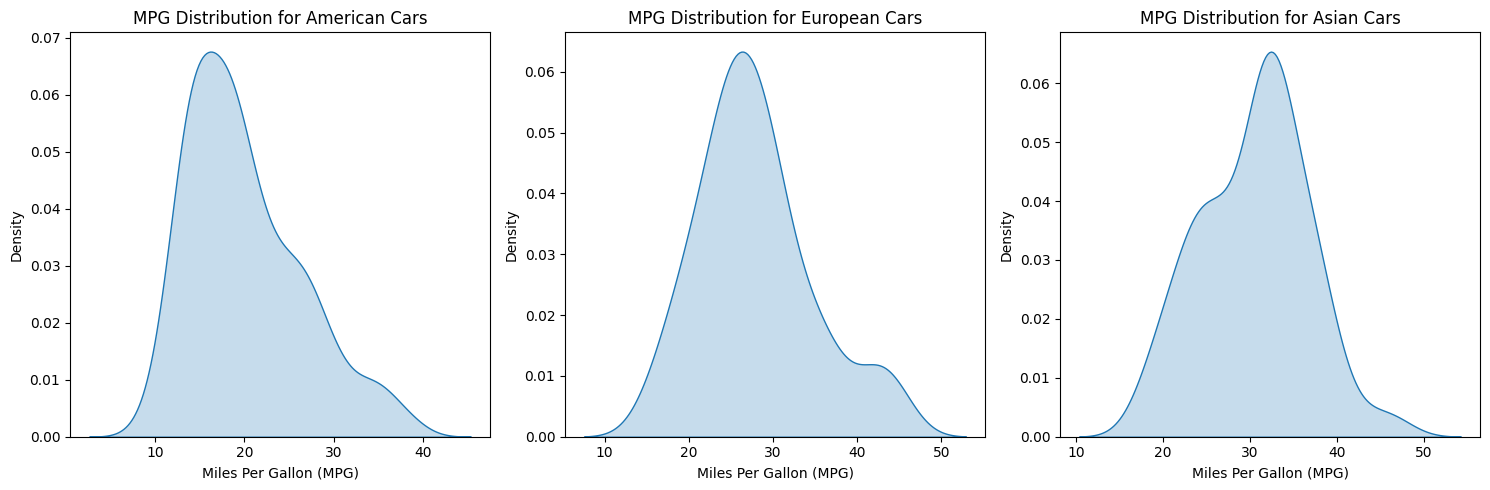

In [16]:
# Create mpg distribution by origin
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.kdeplot(df[df['origin_america'] == True]['mpg'], fill=True, label='America')
plt.title('MPG Distribution for American Cars')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')

plt.subplot(1, 3, 2)
sns.kdeplot(df[df['origin_europe'] == True]['mpg'], fill=True, label='Europe')
plt.title('MPG Distribution for European Cars')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')

plt.subplot(1, 3, 3)
sns.kdeplot(df[df['origin_asia'] == True]['mpg'], fill=True, label='Asia')
plt.title('MPG Distribution for Asian Cars')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


Clearly MPG runs highest for Asian cars, then European ones, and then American ones.

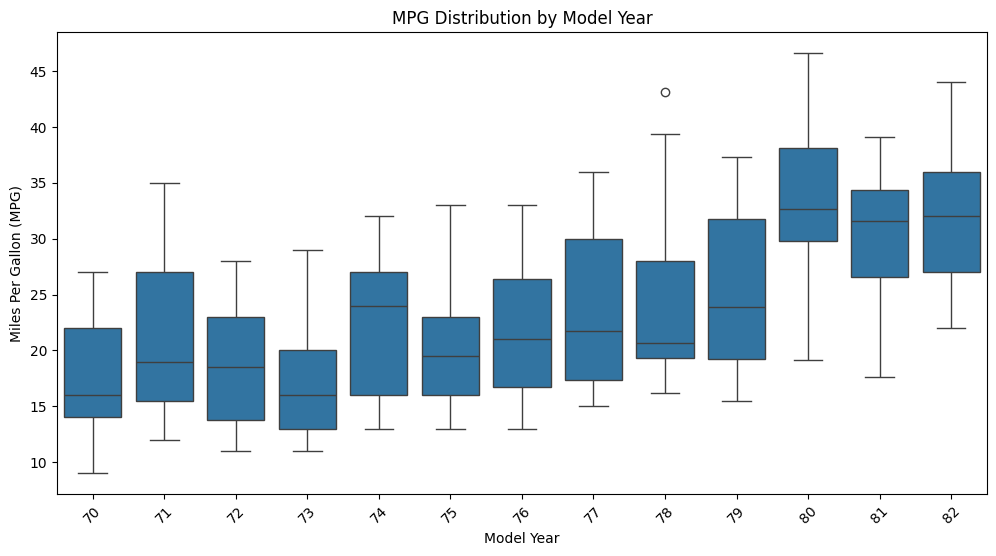

In [17]:
# Let's also look at MPG over the years to detect any trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='mpg', data=df)
plt.title('MPG Distribution by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Miles Per Gallon (MPG)')
plt.xticks(rotation=45)
plt.show()

We can see there is a correlation between model year and mpg as well - with mpg generally trending upward as the years went by. In addition to technology naturally making things more generally efficient over time, I suspect the 70s oil crisis and EPI requirements also had an influence on this...but that's for another study.

### 2.3 Feature selection and engineering


There was a clear association between the car's origin and its mpg. Interestingly, the car name column is not just the model - the first word of every entry appeared to be the vehicle's make. Let's see if we can extract the make of the car as a new column.

#### 2.3.1 Create new features (as applicable).


In [18]:
# Feature engineering: Extract car make from car_name

# Extract the car make (first word) from the car_name column
df['make'] = df['car_name'].str.split().str[0]

# Display the first 10 rows with the new 'make' column
print("First 10 rows with make column added:")
display(df.head(10))

First 10 rows with make column added:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,origin_america,origin_asia,origin_europe,make
0,18.0,8,307.0,130.0,3504.0,12.0,70,chevrolet chevelle malibu,True,False,False,chevrolet
1,15.0,8,350.0,165.0,3693.0,11.5,70,buick skylark 320,True,False,False,buick
2,18.0,8,318.0,150.0,3436.0,11.0,70,plymouth satellite,True,False,False,plymouth
3,16.0,8,304.0,150.0,3433.0,12.0,70,amc rebel sst,True,False,False,amc
4,17.0,8,302.0,140.0,3449.0,10.5,70,ford torino,True,False,False,ford
5,15.0,8,429.0,198.0,4341.0,10.0,70,ford galaxie 500,True,False,False,ford
6,14.0,8,454.0,220.0,4354.0,9.0,70,chevrolet impala,True,False,False,chevrolet
7,14.0,8,440.0,215.0,4312.0,8.5,70,plymouth fury iii,True,False,False,plymouth
8,14.0,8,455.0,225.0,4425.0,10.0,70,pontiac catalina,True,False,False,pontiac
9,15.0,8,390.0,190.0,3850.0,8.5,70,amc ambassador dpl,True,False,False,amc


Looks like it was created successfully! Let's look a little closer to see if we need to do any further work on it.

#### 2.3.2 Transform or combine existing features to improve model performance


In [19]:
# Show the make counts
make_counts = df['make'].value_counts()
print("Current make counts:")
print(make_counts)


Current make counts:
make
ford             51
chevrolet        43
plymouth         31
amc              28
dodge            28
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
oldsmobile       10
mazda            10
peugeot           8
fiat              8
audi              7
vw                6
volvo             6
chrysler          6
renault           5
saab              4
subaru            4
opel              4
chevy             3
cadillac          2
bmw               2
mercedes-benz     2
maxda             2
hi                1
toyouta           1
chevroelt         1
capri             1
mercedes          1
vokswagen         1
triumph           1
nissan            1
Name: count, dtype: int64


We can see most of them are formatted with common names. A handful have strange names or typos - like vw and vokswagen. Let's manually edit them to put them in the bins they belong

##### 2.3.3.1 Transform Makes

In [20]:
# Define mapping dictionary for make standardization
make_mapping = {
    'chevy': 'chevrolet',
    'chevroelt': 'chevrolet',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen',
    'toyouta': 'toyota',
    'mercedes': 'mercedes-benz',
    'maxda': 'mazda',
    'hi': 'hindustan',    # 'hi' appears to be Hindustan Motors
    'capri': 'ford'       # Capri was a model made by Ford
}

# Apply the mapping to standardize makes
df['make'] = df['make'].replace(make_mapping)

# Show the updated make counts
make_counts = df['make'].value_counts()
print("Updated make counts after standardization:")
print(make_counts)

# Display the first 10 rows to verify changes
print("\nFirst 10 rows with standardized make column:")
display(df.head(10))

Updated make counts after standardization:
make
ford             52
chevrolet        47
plymouth         31
amc              28
dodge            28
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
volvo             6
chrysler          6
renault           5
saab              4
opel              4
subaru            4
mercedes-benz     3
bmw               2
cadillac          2
hindustan         1
triumph           1
nissan            1
Name: count, dtype: int64

First 10 rows with standardized make column:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,car_name,origin_america,origin_asia,origin_europe,make
0,18.0,8,307.0,130.0,3504.0,12.0,70,chevrolet chevelle malibu,True,False,False,chevrolet
1,15.0,8,350.0,165.0,3693.0,11.5,70,buick skylark 320,True,False,False,buick
2,18.0,8,318.0,150.0,3436.0,11.0,70,plymouth satellite,True,False,False,plymouth
3,16.0,8,304.0,150.0,3433.0,12.0,70,amc rebel sst,True,False,False,amc
4,17.0,8,302.0,140.0,3449.0,10.5,70,ford torino,True,False,False,ford
5,15.0,8,429.0,198.0,4341.0,10.0,70,ford galaxie 500,True,False,False,ford
6,14.0,8,454.0,220.0,4354.0,9.0,70,chevrolet impala,True,False,False,chevrolet
7,14.0,8,440.0,215.0,4312.0,8.5,70,plymouth fury iii,True,False,False,plymouth
8,14.0,8,455.0,225.0,4425.0,10.0,70,pontiac catalina,True,False,False,pontiac
9,15.0,8,390.0,190.0,3850.0,8.5,70,amc ambassador dpl,True,False,False,amc


Looking much better! Lets check all of the unique makes again:

In [21]:
print("All the unique makes")
print(make_counts)

All the unique makes
make
ford             52
chevrolet        47
plymouth         31
amc              28
dodge            28
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
volvo             6
chrysler          6
renault           5
saab              4
opel              4
subaru            4
mercedes-benz     3
bmw               2
cadillac          2
hindustan         1
triumph           1
nissan            1
Name: count, dtype: int64


##### 2.3.3.2 Confirm Make <-> Origin connection

I hoped to use make as a feature. Part of my intent was that make may provide more information than origin, while also providing some of the information origin did since each make is only from one origin. To prove this I wanted to confirm each set with a specific make all had the same origin.

In [22]:
# Create a function to check if each make has exactly one origin
def check_make_origin_consistency(df):
    # Get unique makes
    makes = df['make'].unique()
    
    # Dictionary to store results
    make_origins = {}
    inconsistent_makes = {}
    
    # Check each make
    for make in makes:
        # Get data for this make
        make_data = df[df['make'] == make]
        
        # Check which origins this make has
        has_america = make_data['origin_america'].any()
        has_asia = make_data['origin_asia'].any()
        has_europe = make_data['origin_europe'].any()
        
        # Count number of origins
        origin_count = sum([has_america, has_asia, has_europe])
        
        # Store the origin
        if has_america:
            make_origins[make] = 'America'
        elif has_asia:
            make_origins[make] = 'Asia'
        elif has_europe:
            make_origins[make] = 'Europe'
        
        # If more than one origin, this make is inconsistent
        if origin_count > 1:
            inconsistent_makes[make] = {
                'America': has_america,
                'Asia': has_asia,
                'Europe': has_europe
            }
    
    return make_origins, inconsistent_makes

# Run the check
make_origins, inconsistent_makes = check_make_origin_consistency(df)

# Show results
print("Number of unique makes:", len(make_origins))
print("\nOrigin countries by make:")
for make, origin in sorted(make_origins.items()):
    print(f"{make}: {origin}")

if inconsistent_makes:
    print("\nWARNING: The following makes have inconsistent origins:")
    for make, origins in inconsistent_makes.items():
        print(f"{make}: {origins}")
else:
    print("\nAll makes have consistent origins!")

Number of unique makes: 29

Origin countries by make:
amc: America
audi: Europe
bmw: Europe
buick: America
cadillac: America
chevrolet: America
chrysler: America
datsun: Asia
dodge: America
fiat: Europe
ford: America
hindustan: America
honda: Asia
mazda: Asia
mercedes-benz: Europe
mercury: America
nissan: Asia
oldsmobile: America
opel: Europe
peugeot: Europe
plymouth: America
pontiac: America
renault: Europe
saab: Europe
subaru: Asia
toyota: Asia
triumph: Europe
volkswagen: Europe
volvo: Europe

All makes have consistent origins!


Looks good! Let's visualize which one each is grouped to:

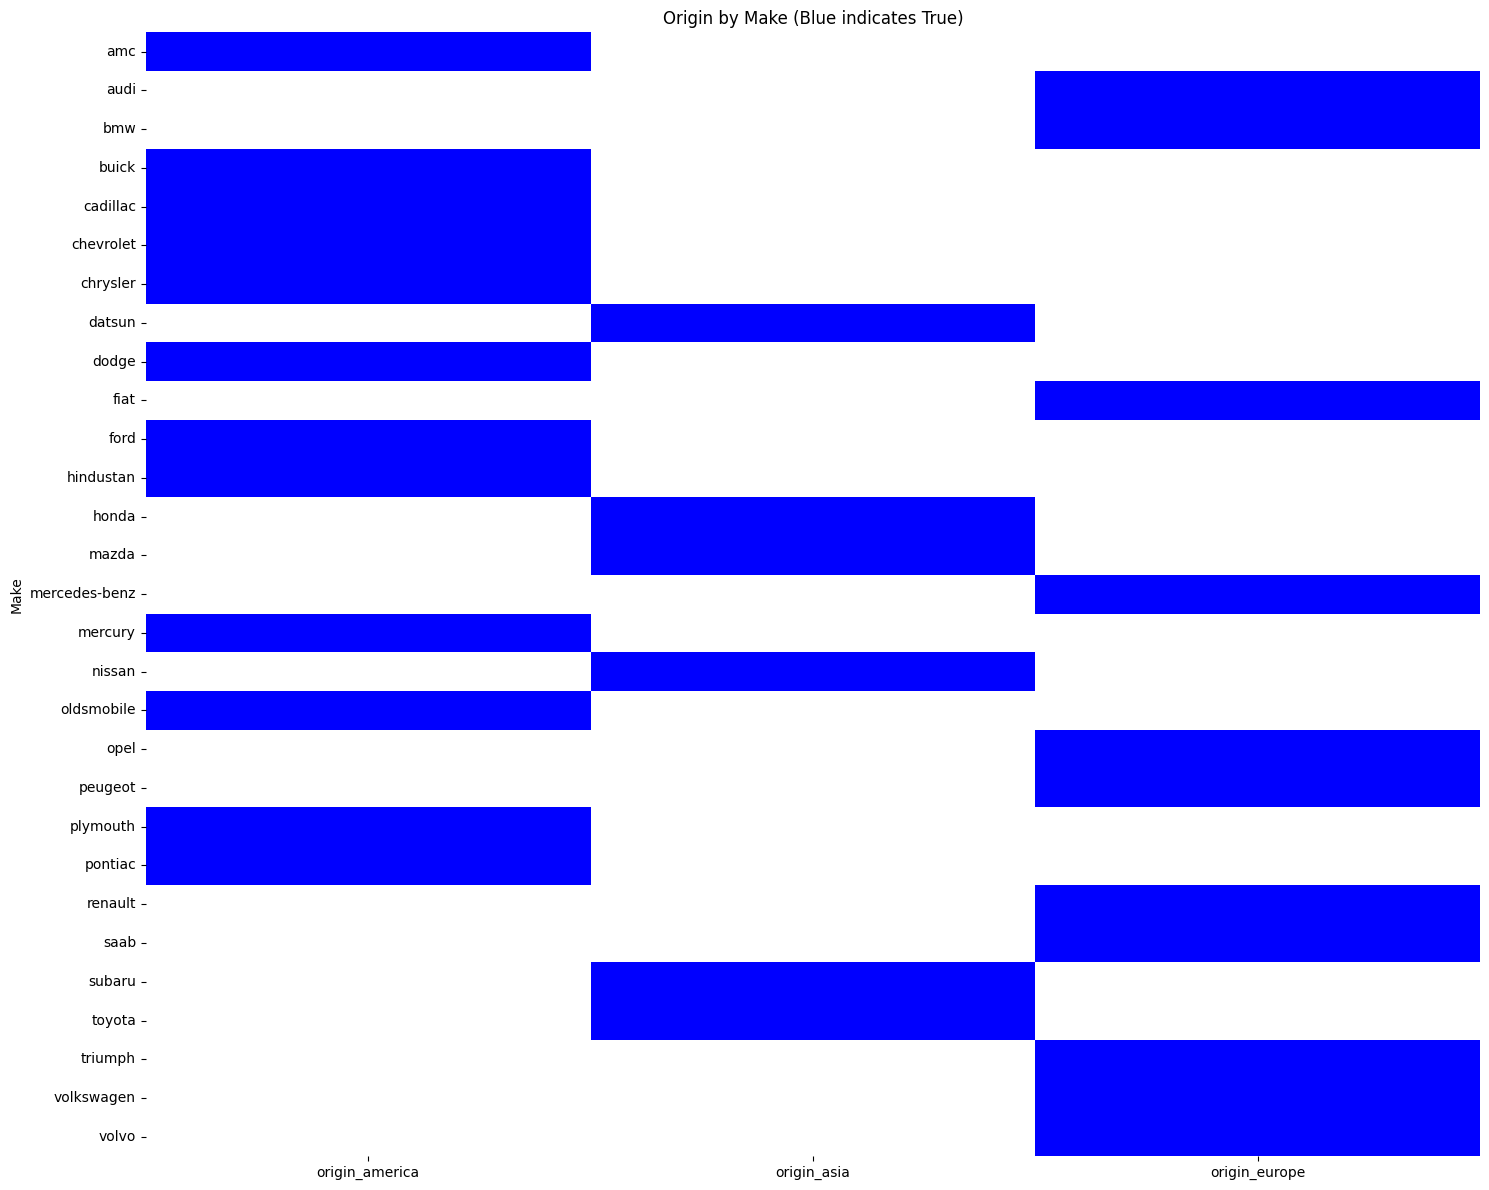

In [23]:
# Create a heatmap showing make-origin relationships
plt.figure(figsize=(15, 12))
# Define a palette that has True as red and False as white/light
# First, create a temporary DataFrame with just the origins
origin_df = df.groupby('make')[['origin_america', 'origin_asia', 'origin_europe']].first()
sns.heatmap(origin_df, cmap=['white', 'blue'], cbar=False)
plt.title('Origin by Make (Blue indicates True)')
plt.ylabel('Make')
plt.tight_layout()
plt.show()

##### 2.3.3.3 Remove Outlier Makes

To avoid confusing the model with low sample count makes, and for the sake of minimizing dimensionality when testing our polynomial model, we removed makes with less than 10 instances in the sample.

While this meant losing 15% of our data set, I was eager enough to use this feature I created that I believed it to be a worthy sacrifice.

In [24]:
# Get value counts of each make
make_counts = df['make'].value_counts()


# Identify makes with fewer than 10 instances
rare_makes = make_counts[make_counts < 10]
print("Makes with fewer than 10 instances:")
print(rare_makes)

# Calculate the total number of cars with these rare makes
rare_makes_count = sum(rare_makes)
total_cars = len(df)
rare_percentage = (rare_makes_count / total_cars) * 100

print(f"\nTotal cars in dataset: {total_cars}")
print(f"Cars with rare makes (< 5 instances): {rare_makes_count}")
print(f"Percentage of dataset with rare makes: {rare_percentage:.2f}%")

Makes with fewer than 10 instances:
make
fiat             8
peugeot          8
audi             7
volvo            6
chrysler         6
renault          5
saab             4
opel             4
subaru           4
mercedes-benz    3
bmw              2
cadillac         2
hindustan        1
triumph          1
nissan           1
Name: count, dtype: int64

Total cars in dataset: 398
Cars with rare makes (< 5 instances): 62
Percentage of dataset with rare makes: 15.58%


In [25]:
# Store the original dataframe size
original_size = len(df)

# Get the list of rare makes (makes with fewer than 5 instances)
rare_makes_list = rare_makes.index.tolist()

# Filter out rows with rare makes
df_filtered = df[~df['make'].isin(rare_makes_list)]

# Calculate the new size
new_size = len(df_filtered)
removed_rows = original_size - new_size

# Display results
print(f"Original dataset size: {original_size} rows")
print(f"After removing rare makes: {new_size} rows")
print(f"Removed {removed_rows} rows ({(removed_rows/original_size)*100:.2f}% of data)")



Original dataset size: 398 rows
After removing rare makes: 336 rows
Removed 62 rows (15.58% of data)


Looks good. This will help greatly in allowing us to use the categorial variable make in our polynomial regression.

Let's take a look at the mpg consumption by make just for the heck of it.

Top 10 makes: ['ford', 'chevrolet', 'plymouth', 'amc', 'dodge', 'toyota', 'datsun', 'volkswagen', 'buick', 'pontiac']


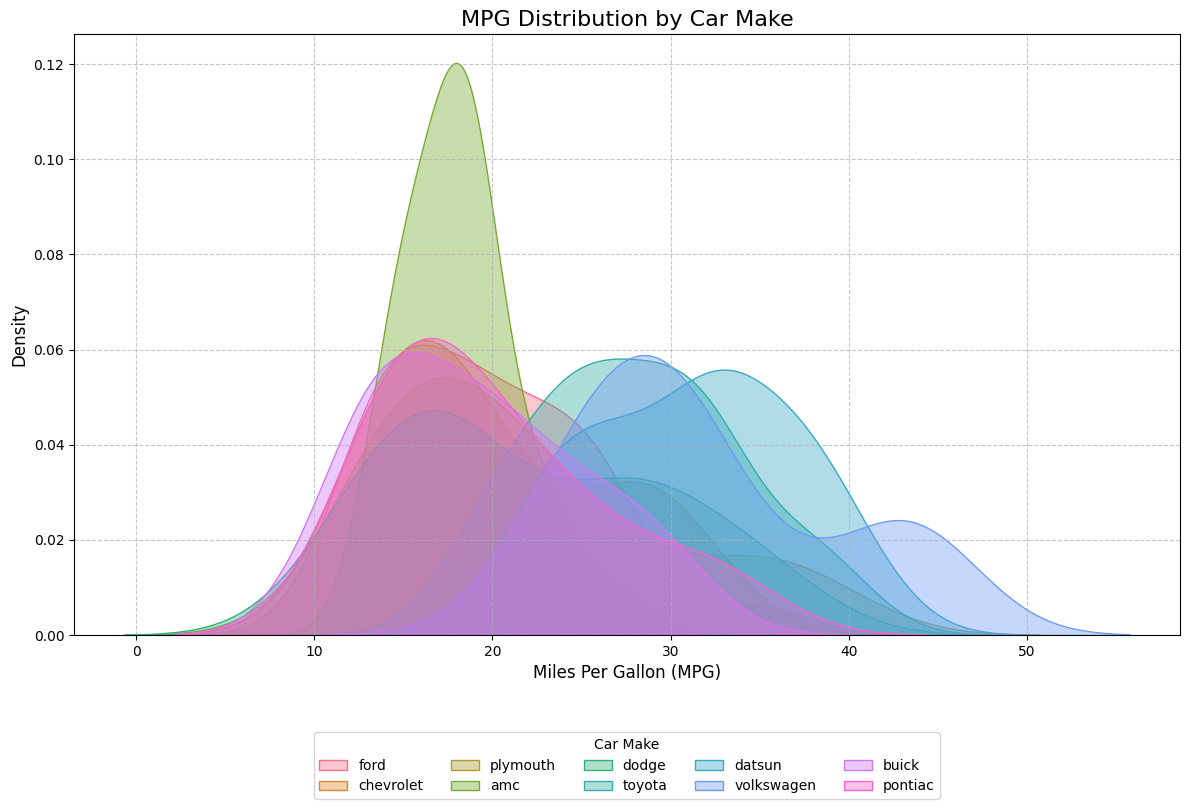

In [26]:
# Get the most common makes (to avoid too many colors in the plot)
top_makes = df['make'].value_counts().head(10).index.tolist()
print(f"Top 10 makes: {top_makes}")

# Filter dataset to include only the top makes for better visualization
filtered_df = df[df['make'].isin(top_makes)]

# Create a figure with adequate size
plt.figure(figsize=(12, 8))

# Use a color palette that distinguishes between different makes
colors = sns.color_palette("husl", len(top_makes))

# Plot KDE curves for each make
for i, make in enumerate(top_makes):
    make_data = filtered_df[filtered_df['make'] == make]
    sns.kdeplot(make_data['mpg'], fill=True, color=colors[i], alpha=0.4, label=make, common_norm=False)

# Add plot details
plt.title('MPG Distribution by Car Make', fontsize=16)
plt.xlabel('Miles Per Gallon (MPG)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend at the bottom
plt.legend(title='Car Make', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5)

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

# Display the plot
plt.show()


We can clearly see the American vehicles have lower humps than the Asian and European ones. Will be interesting to see how our model works with this.

#### 2.3.3 Scale or normalize data (as applicable).



Given how minimal the outliers were in section 2.2.2, this step was skipped, particularly given the features we're using did not have outliers.

### Reflection 2: What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary to clean and improve the data? Did you create or modify any features to improve performance?

Weight showed the strongest negative correlation with MPG (-0.83), while model year demonstrated a clear positive correlation (0.58), reflecting improving fuel economy standards through the 1970s. Origin played a significant role, with Asian and European vehicles generally achieving higher MPG than American ones. I extracted and standardized the 'make' feature from car names. 

Preprocessing included imputing missing horsepower values, encoding categorical features, and filtering out makes with fewer than 10 instances to reduce dimensionality. These steps, especially extracting manufacturer information, will substantially improve the model's predictive power with any luck.


## Section 3. Feature Selection and Justification


### 3.1 Choose features and target


#### 3.1.1 Select two or more input features

We are going to use model year, weight, and make.

Since the data shows a fairly steady upward trend in mpg by model year (as seen in your boxplots), treating it as a numerical feature is likely sufficient and won't cause overfitting. The linear relationship appears reasonably strong.

#### 3.1.2 Select a target variable (as applicable)



The assignment indicated we ought to use MPG. I was hoping I could feed data and use it to predict the origin of the car or the make, and I might in the future as time allows.


#### 3.1.3 Justify your selection with reasoning.


Weight had the strongest correlation with mpg, so that was a no brainer. While Horsepower and displacement had strong associations too, they also had very strong associations with weight, so they would not add new information.

My hope is make adds the same information origin would add, with an extra factor of association to the specific brand. I tested and confirmed it did generally result in higher R^2 values than origin. It is categorical, but by reducing it to the 14 makes with more than 10 samples, my hope is that the model will be able to split and calculate for it effectively.

Lastly, to add time as a factor, we will be using Model Year. Since the data shows a fairly steady upward trend in mpg by model year (as seen in the boxplots), treating it as a numerical feature is likely sufficient and won't cause overfitting.  The linear relationship appears reasonably strong, and it helps us navigate the curse of dimensionality.

### 3.2 Define X and y


#### 3.2.1 Assign input features to X


In [27]:
# 3.2.1 Assign input features to X

# Select the features we want to use for our model
# Convert 'make' to a categorical variable using one-hot encoding
make_encoded = pd.get_dummies(df['make'], prefix='make', drop_first=True)

# Combine the encoded make columns with our other numerical features
X = pd.concat([
    df[['weight', 'model_year']], 
    make_encoded
], axis=1)

# Display the first few rows of our feature set
print("First 5 rows of our features (X):")
display(X.head())

# Shape of the feature matrix
print(f"\nShape of X: {X.shape}")
print(f"Number of features: {X.shape[1]}")

First 5 rows of our features (X):


,weight,model_year,make_audi,make_bmw,make_buick,make_cadillac,make_chevrolet,make_chrysler,make_datsun,make_dodge,...,make_peugeot,make_plymouth,make_pontiac,make_renault,make_saab,make_subaru,make_toyota,make_triumph,make_volkswagen,make_volvo
0,3504.0,70,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3693.0,70,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3436.0,70,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,3433.0,70,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,3449.0,70,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False



Shape of X: (398, 30)
Number of features: 30


#### 3.2.2 Assign target variable to y (as applicable)



First 5 values of our target (y):


0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64


Basic statistics of MPG (target variable):
count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64


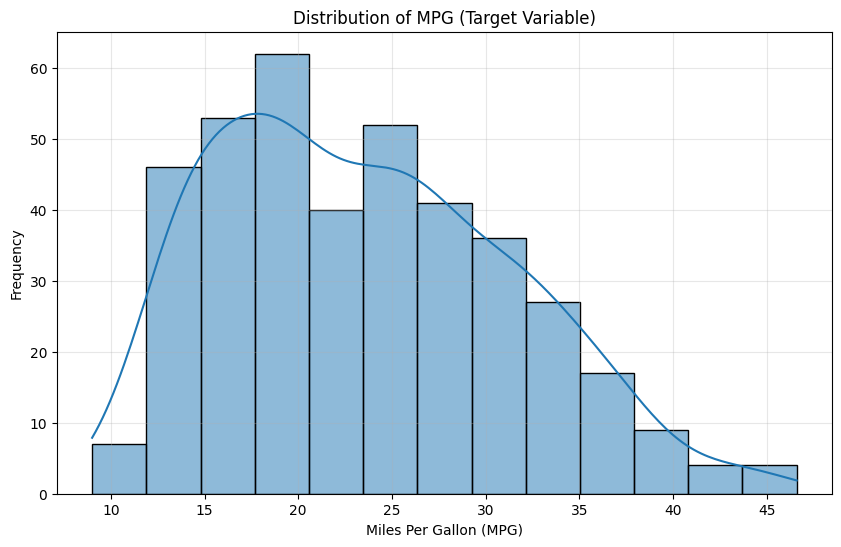

In [28]:
# 3.2.2 Assign target variable to y

# Our target variable is 'mpg'
y = df['mpg']

# Display the first few values of our target
print("First 5 values of our target (y):")
display(y.head())

# Basic statistics of our target variable
print("\nBasic statistics of MPG (target variable):")
print(y.describe())

# Visualize the distribution of our target variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title('Distribution of MPG (Target Variable)')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

### Reflection 3: Why did you choose these features? How might they impact predictions or accuracy?

I selected weight, model year, and make as my predictive features based on both statistical evidence and automotive logic. 

Weight demonstrated the strongest correlation with MPG (-0.83), serving as the most powerful individual predictor while avoiding what I looked up is called 'multicollinearity' with other variables like displacement and horsepower. 

Model year captures the clear upward trend in efficiency over time, likely reflecting both technological advancements and stricter emissions regulations following the 1970s oil crisis. The extracted and standardized 'make' feature offers manufacturer-specific insights beyond the broader 'origin' categorization, allowing the model to capture brand-specific design. Together, these features balance physical vehicle's nature (weight), time-based trends (year), and manufacturer-specific factors for a strong model.


## Section 4. Train a Model (Linear Regression)


### 4.1 Split the data into training and test sets using train_test_split (or StratifiedShuffleSplit if class imbalance is an issue).


#### 4.1.1 Initial Random Split

X_train shape: (318, 30)
X_test shape: (80, 30)
y_train shape: (318,)
y_test shape: (80,)


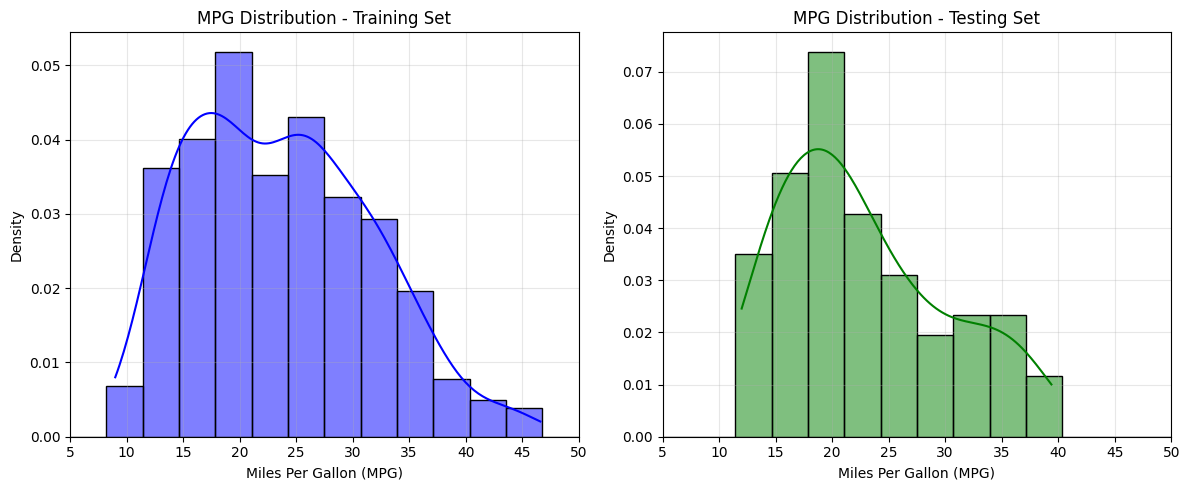


Training set MPG statistics:
count    318.000000
mean      23.706289
std        7.938034
min        9.000000
25%       17.500000
50%       23.350000
75%       29.375000
max       46.600000
Name: mpg, dtype: float64

Testing set MPG statistics:
count    80.000000
mean     22.752500
std       7.308309
min      12.000000
25%      17.000000
50%      21.000000
75%      27.250000
max      39.400000
Name: mpg, dtype: float64


In [29]:
# 4.1 Split the data into training and test sets

# Set a random seed for reproducibility
np.random.seed(state_setter)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state_setter)

# Display the shapes of our training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Create a better comparison of MPG distributions with same bins and normalization
plt.figure(figsize=(12, 5))

# Define common binning
bins = np.linspace(5, 50, 15)  # 15 bins from 5 to 50 MPG

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=bins, kde=True, color='blue', stat='density')
plt.title('MPG Distribution - Training Set')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=bins, kde=True, color='green', stat='density')
plt.title('MPG Distribution - Testing Set')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

plt.tight_layout()
plt.show()

# Compare statistical measures
print("\nTraining set MPG statistics:")
print(y_train.describe())
print("\nTesting set MPG statistics:")
print(y_test.describe())

These distributions are concerningly different. Let's tackle it with a stratified test-train-split...but stratify it across what? 

#### 4.1.2 Stratified Test Train Split - Stratification Comparison

Per our research earlier, there are too many small 'make' bins, so let's consider origin instead. Let's also look at separating MPG into Bins and stratifying according to the bins. We will them compare mpg distributions produced by these 2 methods against the random split we've done here and the original data set's mpg distribution

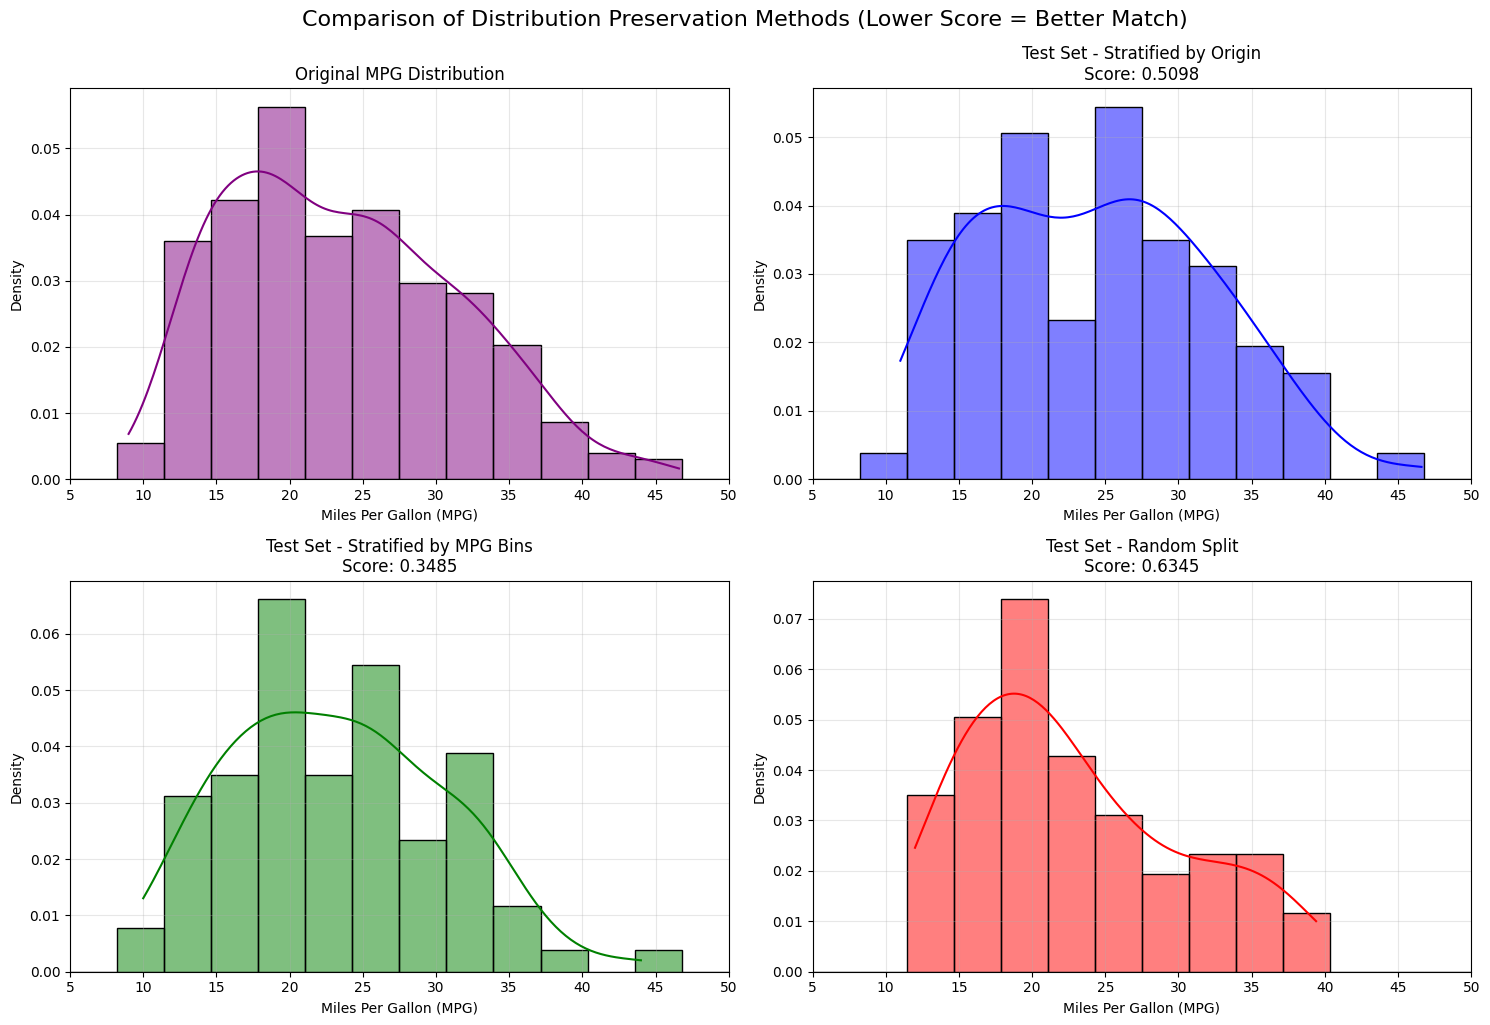

In [30]:

# Function to evaluate similarity between distributions
def compare_distributions(original, sample, method_name):
    # Calculate statistical distances
    ks_stat, ks_pval = ks_2samp(original, sample)
    w_distance = wasserstein_distance(original, sample)
    e_distance = energy_distance(original, sample)
    
    # Calculate basic statistics and their differences
    orig_stats = original.describe()
    sample_stats = sample.describe()
    
    # Calculate absolute differences in key statistics
    mean_diff = abs(orig_stats['mean'] - sample_stats['mean'])
    std_diff = abs(orig_stats['std'] - sample_stats['std'])
    
    # Quartile differences
    q1_diff = abs(orig_stats['25%'] - sample_stats['25%'])
    median_diff = abs(orig_stats['50%'] - sample_stats['50%'])
    q3_diff = abs(orig_stats['75%'] - sample_stats['75%'])
    
   
    # Return a composite score 
    # Weighted sum of distances
    composite_score = (ks_stat * 0.3) + (w_distance * 0.3) + (e_distance * 0.1) + \
                      (mean_diff * 0.1) + (std_diff * 0.1) + \
                      (q1_diff * 0.03) + (median_diff * 0.04) + (q3_diff * 0.03)
    
    """The score is a weighted combination of several statistical distance metrics:

    Kolmogorov-Smirnov statistic (30% weight): Measures the maximum difference between two cumulative distribution functions. A value of 0 means identical distributions.
    Wasserstein distance (30% weight): Also known as the "Earth Mover's Distance," it measures how much "work" it would take to transform one distribution into another. Lower values mean distributions are more similar.
    Energy distance (10% weight): Another statistical distance metric that's sensitive to differences in both shape and location of distributions.
    Differences in key statistics (30% total weight):

    Mean difference (10%)
    Standard deviation difference (10%)
    Quartile differences (10% total: 3% for Q1, 4% for median, 3% for Q3)

    These components capture different aspects of distribution similarity:

    The statistical distance metrics (KS, Wasserstein, Energy) capture overall shape differences
    The mean and standard deviation differences capture central tendency and spread
    The quartile differences capture structural details of the distribution"""


    return {
        'method': method_name,
        'ks_stat': ks_stat,
        'ks_pval': ks_pval,
        'w_distance': w_distance,
        'e_distance': e_distance,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'q1_diff': q1_diff,
        'median_diff': median_diff,
        'q3_diff': q3_diff,
        'composite_score': composite_score
    }

# Original data
y_original = df['mpg']

# Prepare features (same as before)
make_encoded = pd.get_dummies(df['make'], prefix='make', drop_first=True)
X = pd.concat([df[['weight', 'model_year']], make_encoded], axis=1)

# Method 1: Stratify by origin
strat_var_origin = np.where(df['origin_america'], 'america', 
                   np.where(df['origin_europe'], 'europe', 'asia'))

X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(
    X, y_original, 
    test_size=0.2, 
    random_state=state_setter,
    stratify=strat_var_origin
)

# Method 2: Stratify by 5 binned MPG values
mpg_bins = pd.qcut(df['mpg'], q=5, labels=False, duplicates='drop')

X_train_mpg, X_test_mpg, y_train_mpg, y_test_mpg = train_test_split(
    X, y_original, 
    test_size=0.2, 
    random_state=state_setter,
    stratify=mpg_bins
)

# Method 3: Regular random split (as baseline)
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
    X, y_original, 
    test_size=0.2, 
    random_state=state_setter
)

# Compare distributions
origin_results = compare_distributions(y_original, y_test_origin, "Origin")
mpg_results = compare_distributions(y_original, y_test_mpg, "MPG Bins")
random_results = compare_distributions(y_original, y_test_rand, "Random")
# Visualize all distributions
plt.figure(figsize=(15, 10))

# Define common binning
bins = np.linspace(5, 50, 15)

# Original distribution
plt.subplot(2, 2, 1)
sns.histplot(y_original, bins=bins, kde=True, color='purple', stat='density')
plt.title('Original MPG Distribution')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

# Origin stratification
plt.subplot(2, 2, 2)
sns.histplot(y_test_origin, bins=bins, kde=True, color='blue', stat='density')
plt.title(f'Test Set - Stratified by Origin\nScore: {origin_results["composite_score"]:.4f}')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

# MPG bins stratification
plt.subplot(2, 2, 3)
sns.histplot(y_test_mpg, bins=bins, kde=True, color='green', stat='density')
plt.title(f'Test Set - Stratified by MPG Bins\nScore: {mpg_results["composite_score"]:.4f}')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

# Random split
plt.subplot(2, 2, 4)
sns.histplot(y_test_rand, bins=bins, kde=True, color='red', stat='density')
plt.title(f'Test Set - Random Split\nScore: {random_results["composite_score"]:.4f}')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

plt.tight_layout()
plt.suptitle('Comparison of Distribution Preservation Methods (Lower Score = Better Match)', fontsize=16, y=1.02)
plt.show()

This suggests mpg bins is the best, and visually it definitely appears closest too. Given the small set of the data however, let's cross-validate across 10 splits to confirm we achieve the same results.

Note - the score represents the dissimilarity between the test set distribution and the original distribution. Lower scores indicate test sets that more closely match the original MPG distribution, which is why lower is better, and 0 would mean the distributions are identical.

If curious for more detail, review the comments and calculations in the python code.

#### 4.1.3 Cross Validated Stratification Factor Comparison

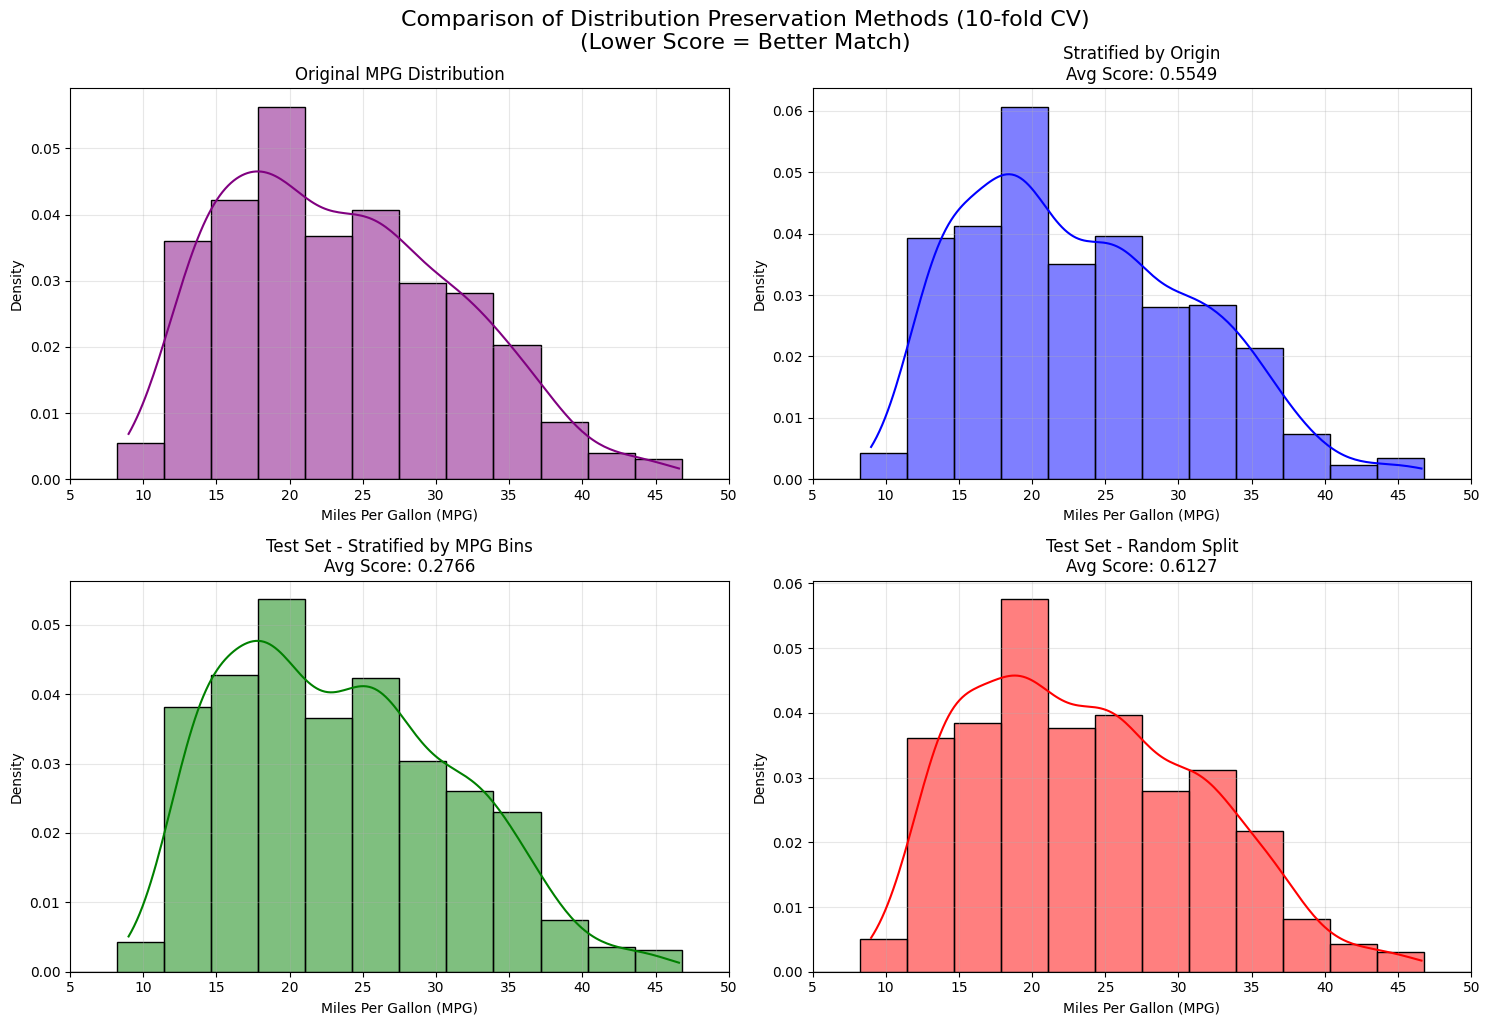


--- Summary of Average Distribution Similarity Across 10 Splits ---
           ks_stat  w_distance  mean_diff  std_diff  composite_score
method                                                              
MPG Bins  0.052469    0.515113   0.162250  0.295890         0.276640
Origin    0.094805    0.941481   0.738579  0.216741         0.554919
Random    0.091884    1.048939   0.795796  0.548880         0.612670

Best stratification method: MPG Bins

--- Standard Deviation of Scores Across 10 Splits ---
Origin: 0.1189
MPG Bins: 0.0478
Random: 0.2200


In [31]:
# Function to evaluate similarity between distributions
def compare_distributions(original, sample, method_name):
    # Calculate statistical distances
    ks_stat, ks_pval = ks_2samp(original, sample)
    w_distance = wasserstein_distance(original, sample)
    e_distance = energy_distance(original, sample)
    
    # Calculate basic statistics and their differences
    orig_stats = original.describe()
    sample_stats = sample.describe()
    
    # Calculate absolute differences in key statistics
    mean_diff = abs(orig_stats['mean'] - sample_stats['mean'])
    std_diff = abs(orig_stats['std'] - sample_stats['std'])
    
    # Quartile differences
    q1_diff = abs(orig_stats['25%'] - sample_stats['25%'])
    median_diff = abs(orig_stats['50%'] - sample_stats['50%'])
    q3_diff = abs(orig_stats['75%'] - sample_stats['75%'])
    
    # Return a composite score  
    # Weighted sum of distances
    composite_score = (ks_stat * 0.3) + (w_distance * 0.3) + (e_distance * 0.1) + \
                      (mean_diff * 0.1) + (std_diff * 0.1) + \
                      (q1_diff * 0.03) + (median_diff * 0.04) + (q3_diff * 0.03)
    
    return {
        'method': method_name,
        'ks_stat': ks_stat,
        'ks_pval': ks_pval,
        'w_distance': w_distance,
        'e_distance': e_distance,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'q1_diff': q1_diff,
        'median_diff': median_diff,
        'q3_diff': q3_diff,
        'composite_score': composite_score
    }

# Original data
y_original = df['mpg']

# Prepare features (same as before)
make_encoded = pd.get_dummies(df['make'], prefix='make', drop_first=True)
X = pd.concat([df[['weight', 'model_year']], make_encoded], axis=1)

# Number of cross-validation iterations
n_iterations = 10

# Initialize dictionaries to store results and test set distributions
results_origin = []
results_mpg = []
results_random = []

# Initialize arrays to accumulate histograms for averaging
all_y_test_origin = []
all_y_test_mpg = []
all_y_test_random = []

# Cross-validation loop
for i in range(n_iterations):
    # Set random state based on state_setter + iteration
    random_state = state_setter + i
    
    # Method 1: Stratify by origin
    strat_var_origin = np.where(df['origin_america'], 'america', 
                    np.where(df['origin_europe'], 'europe', 'asia'))

    X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(
        X, y_original, 
        test_size=0.2, 
        random_state=random_state,
        stratify=strat_var_origin
    )
    
 
    mpg_bins = pd.qcut(df['mpg'], q=5, labels=False, duplicates='drop')




    X_train_mpg, X_test_mpg, y_train_mpg, y_test_mpg = train_test_split(
        X, y_original, 
        test_size=0.2, 
        random_state=random_state,
        stratify=mpg_bins
    )
    
    # Method 3: Regular random split (as baseline)
    X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(
        X, y_original, 
        test_size=0.2, 
        random_state=random_state
    )
    
    # Evaluate distributions
    results_origin.append(compare_distributions(y_original, y_test_origin, "Origin"))
    results_mpg.append(compare_distributions(y_original, y_test_mpg, "MPG Bins"))
    results_random.append(compare_distributions(y_original, y_test_rand, "Random"))
    
    # Store test set distributions for later averaging
    all_y_test_origin.append(y_test_origin)
    all_y_test_mpg.append(y_test_mpg)
    all_y_test_random.append(y_test_rand)

# Calculate average scores for each method
def average_results(results_list):
    avg_results = {
        'ks_stat': np.mean([r['ks_stat'] for r in results_list]),
        'ks_pval': np.mean([r['ks_pval'] for r in results_list]),
        'w_distance': np.mean([r['w_distance'] for r in results_list]),
        'e_distance': np.mean([r['e_distance'] for r in results_list]),
        'mean_diff': np.mean([r['mean_diff'] for r in results_list]),
        'std_diff': np.mean([r['std_diff'] for r in results_list]),
        'q1_diff': np.mean([r['q1_diff'] for r in results_list]),
        'median_diff': np.mean([r['median_diff'] for r in results_list]),
        'q3_diff': np.mean([r['q3_diff'] for r in results_list]),
        'composite_score': np.mean([r['composite_score'] for r in results_list])
    }
    return avg_results

avg_origin = average_results(results_origin)
avg_mpg = average_results(results_mpg)
avg_random = average_results(results_random)

# Function to create a combined histogram representation across all CV iterations
def create_averaged_histogram(all_samples, bins=15):
    # Concatenate all samples across CV iterations
    combined = pd.concat(all_samples)
    return combined

# Create averaged histograms
avg_hist_origin = create_averaged_histogram(all_y_test_origin)
avg_hist_mpg = create_averaged_histogram(all_y_test_mpg)
avg_hist_random = create_averaged_histogram(all_y_test_random)

# Visualize the average distributions
plt.figure(figsize=(15, 10))

# Define common binning
bins = np.linspace(5, 50, 15)

# Original distribution
plt.subplot(2, 2, 1)
sns.histplot(y_original, bins=bins, kde=True, color='purple', stat='density')
plt.title('Original MPG Distribution')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

# Origin stratification (average across CV)
plt.subplot(2, 2, 2)
sns.histplot(avg_hist_origin, bins=bins, kde=True, color='blue', stat='density')
plt.title(f'Stratified by Origin\nAvg Score: {avg_origin["composite_score"]:.4f}')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

# MPG bins stratification (average across CV)
plt.subplot(2, 2, 3)
sns.histplot(avg_hist_mpg, bins=bins, kde=True, color='green', stat='density')
plt.title(f'Test Set - Stratified by MPG Bins\nAvg Score: {avg_mpg["composite_score"]:.4f}')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

# Random split (average across CV)
plt.subplot(2, 2, 4)
sns.histplot(avg_hist_random, bins=bins, kde=True, color='red', stat='density')
plt.title(f'Test Set - Random Split\nAvg Score: {avg_random["composite_score"]:.4f}')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

plt.tight_layout()
plt.suptitle('Comparison of Distribution Preservation Methods (10-fold CV)\n(Lower Score = Better Match)', fontsize=16, y=1.02)
plt.show()

# Create a summary table of average results
methods = [
    {'method': 'Origin', **avg_origin},
    {'method': 'MPG Bins', **avg_mpg},
    {'method': 'Random', **avg_random}
]
comparison_df = pd.DataFrame(methods)
comparison_df = comparison_df.set_index('method')

# Sort by composite score (lower is better)
comparison_df = comparison_df.sort_values('composite_score')

print("\n--- Summary of Average Distribution Similarity Across 10 Splits ---")
print(comparison_df[['ks_stat', 'w_distance', 'mean_diff', 'std_diff', 'composite_score']])

# Determine the winner
winner = comparison_df.index[0]
print(f"\nBest stratification method: {winner}")

# Show standard deviation of scores to see consistency
std_origin = np.std([r['composite_score'] for r in results_origin])
std_mpg = np.std([r['composite_score'] for r in results_mpg])
std_random = np.std([r['composite_score'] for r in results_random])

print("\n--- Standard Deviation of Scores Across 10 Splits ---")
print(f"Origin: {std_origin:.4f}")
print(f"MPG Bins: {std_mpg:.4f}")
print(f"Random: {std_random:.4f}")

This clearly confirms the mpg binning method gave the lowest score, and a distribution closest to the original. No surprise given the distribution of mpg itself is what we're interested in! But still wise to cross-validate.

Stratifying the split across a greater number of bins should obviously help it match the the original distribution, but let's double check that and also confirm there aren't major performance implications. With our smaller data set, it probably won't have performance implications, but let's double check and confirm a larger number of bins is ideal.

#### 4.1.4 Bin Count Stratification Fine Tuning

<Figure size 1500x1000 with 0 Axes>

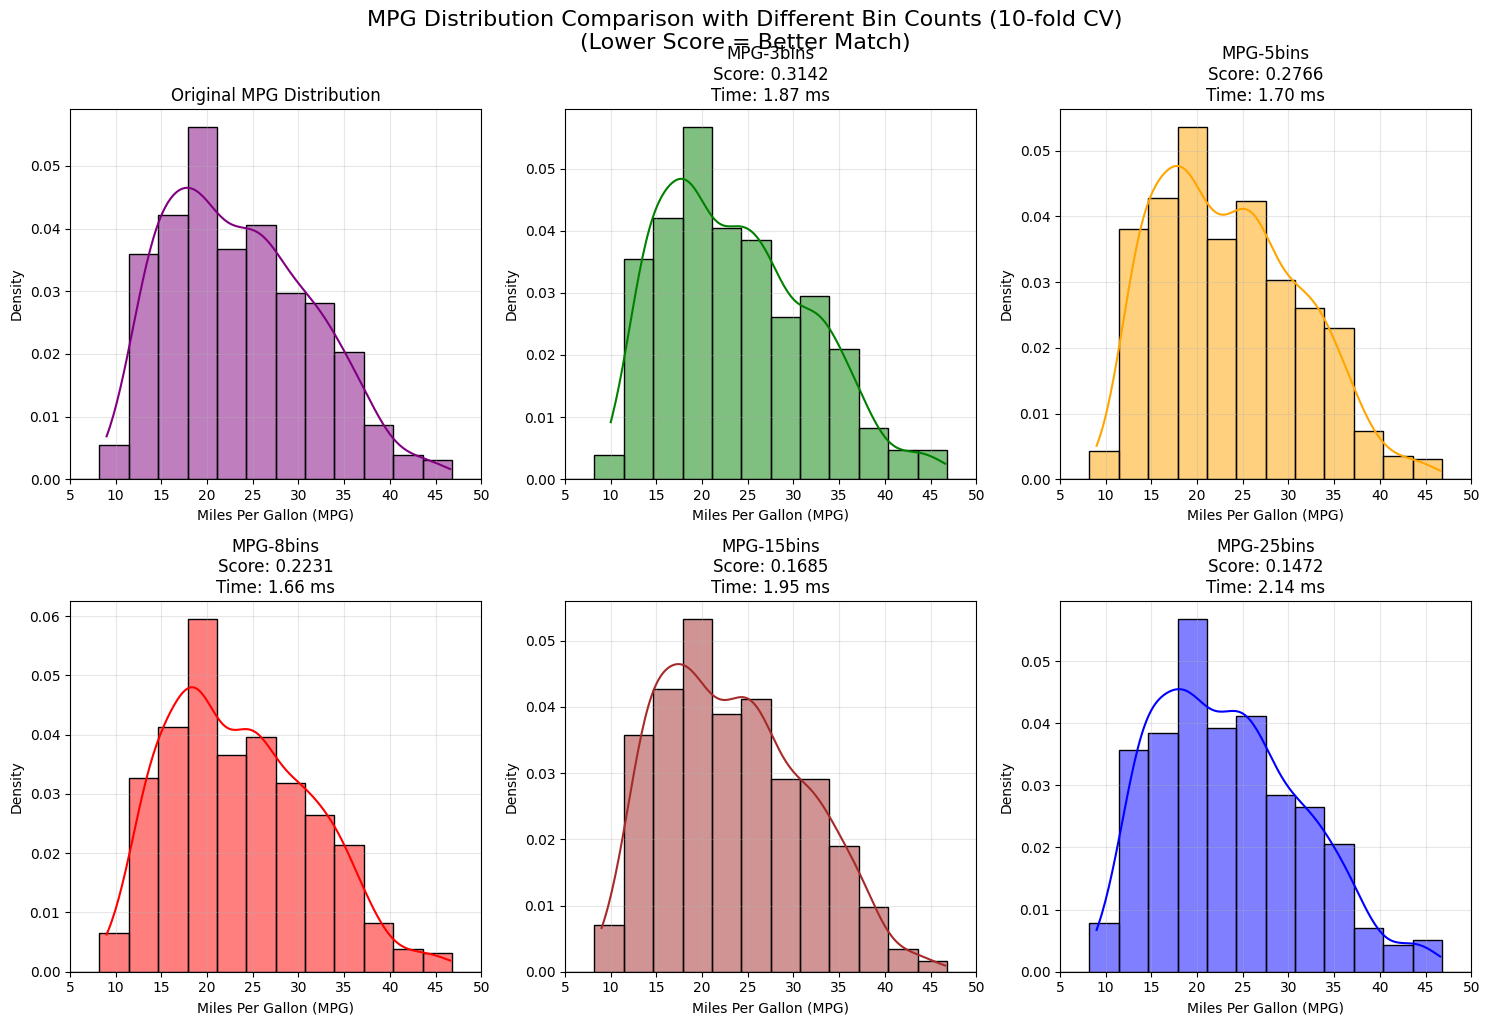

In [32]:
# Function to evaluate similarity between distributions (same as before)
def compare_distributions(original, sample, method_name):
    # Calculate statistical distances
    ks_stat, ks_pval = ks_2samp(original, sample)
    w_distance = wasserstein_distance(original, sample)
    e_distance = energy_distance(original, sample)
    
    # Calculate basic statistics and their differences
    orig_stats = original.describe()
    sample_stats = sample.describe()
    
    # Calculate absolute differences in key statistics
    mean_diff = abs(orig_stats['mean'] - sample_stats['mean'])
    std_diff = abs(orig_stats['std'] - sample_stats['std'])
    
    # Quartile differences
    q1_diff = abs(orig_stats['25%'] - sample_stats['25%'])
    median_diff = abs(orig_stats['50%'] - sample_stats['50%'])
    q3_diff = abs(orig_stats['75%'] - sample_stats['75%'])
    
    # Return a composite score (lower is better)
    composite_score = (ks_stat * 0.3) + (w_distance * 0.3) + (e_distance * 0.1) + \
                      (mean_diff * 0.1) + (std_diff * 0.1) + \
                      (q1_diff * 0.03) + (median_diff * 0.04) + (q3_diff * 0.03)
    
    return {
        'method': method_name,
        'ks_stat': ks_stat,
        'ks_pval': ks_pval,
        'w_distance': w_distance,
        'e_distance': e_distance,
        'mean_diff': mean_diff,
        'std_diff': std_diff,
        'q1_diff': q1_diff,
        'median_diff': median_diff,
        'q3_diff': q3_diff,
        'composite_score': composite_score
    }

# Original data
y_original = df['mpg']

# Prepare features
make_encoded = pd.get_dummies(df['make'], prefix='make', drop_first=True)
X = pd.concat([df[['weight', 'model_year']], make_encoded], axis=1)

# Number of cross-validation iterations
n_iterations = 10

# Different bin counts to test
bin_counts = [3, 5, 8, 15, 25]

# Dictionary to store results for different bin counts
bin_results = {}
bin_times = {}
all_distributions = {}

# Baseline: Origin stratification for comparison
all_y_test_origin = []
results_origin = []
origin_times = []

# Run cross-validation for origin stratification as baseline
for i in range(n_iterations):
    random_state = state_setter + i
    
    # Measure time for origin stratification
    start_time = time.time()
    
    # Method: Stratify by origin
    strat_var_origin = np.where(df['origin_america'], 'america', 
                     np.where(df['origin_europe'], 'europe', 'asia'))

    X_train_origin, X_test_origin, y_train_origin, y_test_origin = train_test_split(
        X, y_original, 
        test_size=0.2, 
        random_state=random_state,
        stratify=strat_var_origin
    )
    
    end_time = time.time()
    origin_times.append(end_time - start_time)
    
    # Evaluate distribution
    results_origin.append(compare_distributions(y_original, y_test_origin, "Origin"))
    all_y_test_origin.append(y_test_origin)

# Average origin results
avg_origin = {
    'ks_stat': np.mean([r['ks_stat'] for r in results_origin]),
    'w_distance': np.mean([r['w_distance'] for r in results_origin]),
    'mean_diff': np.mean([r['mean_diff'] for r in results_origin]),
    'std_diff': np.mean([r['std_diff'] for r in results_origin]),
    'composite_score': np.mean([r['composite_score'] for r in results_origin])
}
avg_origin_time = np.mean(origin_times)

# Run cross-validation for each bin count
for bin_count in bin_counts:
    method_name = f"MPG-{bin_count}bins"
    bin_results[method_name] = []
    bin_times[method_name] = []
    all_distributions[method_name] = []
    
    for i in range(n_iterations):
        random_state = state_setter + i
        
        # Measure time
        start_time = time.time()
        
        # Create bins and stratify
        mpg_bins = pd.qcut(df['mpg'], q=bin_count, labels=False, duplicates='drop')

        
        X_train_bins, X_test_bins, y_train_bins, y_test_bins = train_test_split(
            X, y_original, 
            test_size=0.2, 
            random_state=random_state,
            stratify=mpg_bins
        )
        
        end_time = time.time()
        bin_times[method_name].append(end_time - start_time)
        
        # Evaluate distribution
        bin_results[method_name].append(compare_distributions(y_original, y_test_bins, method_name))
        all_distributions[method_name].append(y_test_bins)

# Calculate averages for each bin count
avg_results = {}
for method_name in bin_results:
    avg_results[method_name] = {
        'ks_stat': np.mean([r['ks_stat'] for r in bin_results[method_name]]),
        'w_distance': np.mean([r['w_distance'] for r in bin_results[method_name]]),
        'mean_diff': np.mean([r['mean_diff'] for r in bin_results[method_name]]),
        'std_diff': np.mean([r['std_diff'] for r in bin_results[method_name]]),
        'composite_score': np.mean([r['composite_score'] for r in bin_results[method_name]])
    }

# Average times
avg_times = {method: np.mean(times) for method, times in bin_times.items()}

# Function to create a combined histogram
def create_averaged_histogram(all_samples):
    return pd.concat(all_samples)

# Create averaged histograms
avg_hist_origin = create_averaged_histogram(all_y_test_origin)
avg_hist_bins = {method: create_averaged_histogram(dists) 
                for method, dists in all_distributions.items()}

# Visualize the distributions
plt.figure(figsize=(15, 10))
bins = np.linspace(5, 50, 15)

# Visualize the distributions
plt.figure(figsize=(15, 10))
bins = np.linspace(5, 50, 15)

# Original distribution
plt.subplot(2, 3, 1)
sns.histplot(y_original, bins=bins, kde=True, color='purple', stat='density')
plt.title('Original MPG Distribution')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

# Different bin counts
colors = ['green', 'orange', 'red', 'brown', 'blue']  # Added blue as the 5th color
subplot_positions = [2, 3, 4, 5, 6]  # Using all positions in the 2x3 grid

for i, ((method, dist), color, pos) in enumerate(zip(avg_hist_bins.items(), colors, subplot_positions)):
    plt.subplot(2, 3, pos)
    sns.histplot(dist, bins=bins, kde=True, color=color, stat='density')
    plt.title(f'{method}\nScore: {avg_results[method]["composite_score"]:.4f}\nTime: {avg_times[method]*1000:.2f} ms')
    plt.xlabel('Miles Per Gallon (MPG)')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)
    plt.xlim(5, 50)

plt.tight_layout()
plt.suptitle('MPG Distribution Comparison with Different Bin Counts (10-fold CV)\n(Lower Score = Better Match)', fontsize=16, y=1.02)
plt.show()

# Create a summary table
summary_data = []

# Add origin as baseline
summary_data.append({
    'Method': 'Origin',
    'Score': avg_origin['composite_score'],
    'Time (ms)': avg_origin_time * 1000,
    'KS Stat': avg_origin['ks_stat'],
    'W-Distance': avg_origin['w_distance'],
    'Mean Diff': avg_origin['mean_diff'],
    'Std Diff': avg_origin['std_diff']
})

# Add bin methods
for method in avg_results:
    summary_data.append({
        'Method': method,
        'Score': avg_results[method]['composite_score'],
        'Time (ms)': avg_times[method] * 1000,
        'KS Stat': avg_results[method]['ks_stat'],
        'W-Distance': avg_results[method]['w_distance'],
        'Mean Diff': avg_results[method]['mean_diff'],
        'Std Diff': avg_results[method]['std_diff']
    })

summary_df = pd.DataFrame(summary_data)


For our small data set, using a big bin count still worked out! We'll use 25 bins in our final stratification.

A couple notes:
- The 15 bin and 25 bin distributions were mapped to 12 bin diagrams for easy comparison across splits.
- Bin Counts over 25, some bins only had a single sample and thus couldn't be stratified. 25 turned out to be the max we could support, which conveniently does not have performance implications for our data set.

#### 4.1.5 Stratified Test Train Split
We are finally ready to split the data! We will split it across 25 bins for mpg to keep the distribution equal.

X_train shape: (318, 30)
X_test shape: (80, 30)
y_train shape: (318,)
y_test shape: (80,)


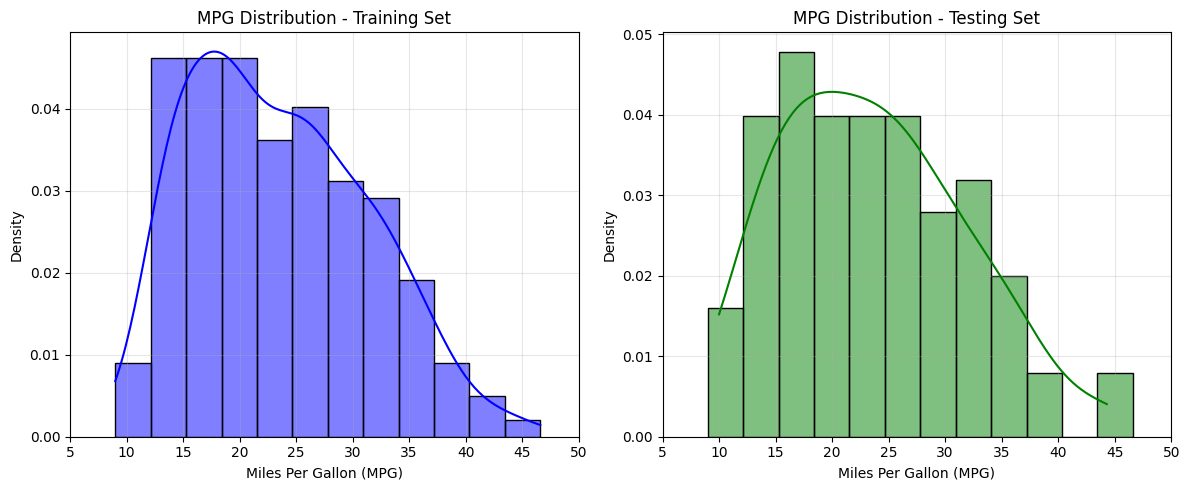


Training set MPG statistics:
count    318.000000
mean      23.486792
std        7.768050
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

Testing set MPG statistics:
count    80.000000
mean     23.625000
std       8.052635
min      10.000000
25%      17.525000
50%      23.000000
75%      29.000000
max      44.300000
Name: mpg, dtype: float64

Final test set similarity score: 0.1335


In [33]:
# 4.1.5 Test Train Split using MPG stratification with 25 bins

# Original data
y = df['mpg']

# Prepare features
make_encoded = pd.get_dummies(df['make'], prefix='make', drop_first=True)
X = pd.concat([df[['weight', 'model_year']], make_encoded], axis=1)

# Create 25 mpg bins for stratification (our optimal bin count from earlier analysis)
mpg_bins = pd.qcut(df['mpg'], q=25, labels=False, duplicates='drop')

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=state_setter,
    stratify=mpg_bins
)

# Display the shapes of our training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Visualize our final train/test distributions with the same number of bins
plt.figure(figsize=(12, 5))

# Define a fixed set of bins for both plots - using exactly 12 bins
fixed_bins = np.linspace(y.min(), y.max(), 13)  # 13 edges = 12 bins

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=fixed_bins, kde=True, color='blue', stat='density')
plt.title('MPG Distribution - Training Set')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

plt.subplot(1, 2, 2)
sns.histplot(y_test, bins=fixed_bins, kde=True, color='green', stat='density')
plt.title('MPG Distribution - Testing Set')
plt.xlabel('Miles Per Gallon (MPG)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.xlim(5, 50)

plt.tight_layout()
plt.show()

# Compare statistical measures to verify balance
print("\nTraining set MPG statistics:")
print(y_train.describe())
print("\nTesting set MPG statistics:")
print(y_test.describe())

# Calculate distribution similarity score between original and test set
similarity_score = compare_distributions(y, y_test, "Final Split")
print(f"\nFinal test set similarity score: {similarity_score['composite_score']:.4f}")

Looks good. Onward to training.

### 4.2 Train model using Scikit-Learn model.fit() method


Model trained in 0.0035 seconds

Model Parameters:
Intercept: -17.4512

Top 10 most influential features:


,Feature,Coefficient,Abs_Coefficient
27,make_triumph,7.774030,7.774030
23,make_renault,6.273595,6.273595
17,make_nissan,5.275130,5.275130
13,make_honda,4.515573,4.515573
8,make_datsun,4.454915,4.454915
10,make_fiat,4.162342,4.162342
15,make_mercedes-benz,4.094901,4.094901
28,make_volkswagen,3.729828,3.729828
5,make_cadillac,3.373356,3.373356
2,make_audi,3.006568,3.006568



Sample of Actual vs. Predicted values (Test Set):


,Actual,Predicted,Residual
254,20.2,23.266875,-3.066875
315,24.3,24.249247,0.050753
382,34.0,32.293879,1.706121
268,27.2,31.377671,-4.177671
55,27.0,28.206541,-1.206541
35,17.0,16.851893,0.148107
311,32.1,30.697284,1.402716
168,23.0,22.965922,0.034078
14,24.0,22.621497,1.378503
133,16.0,16.407186,-0.407186


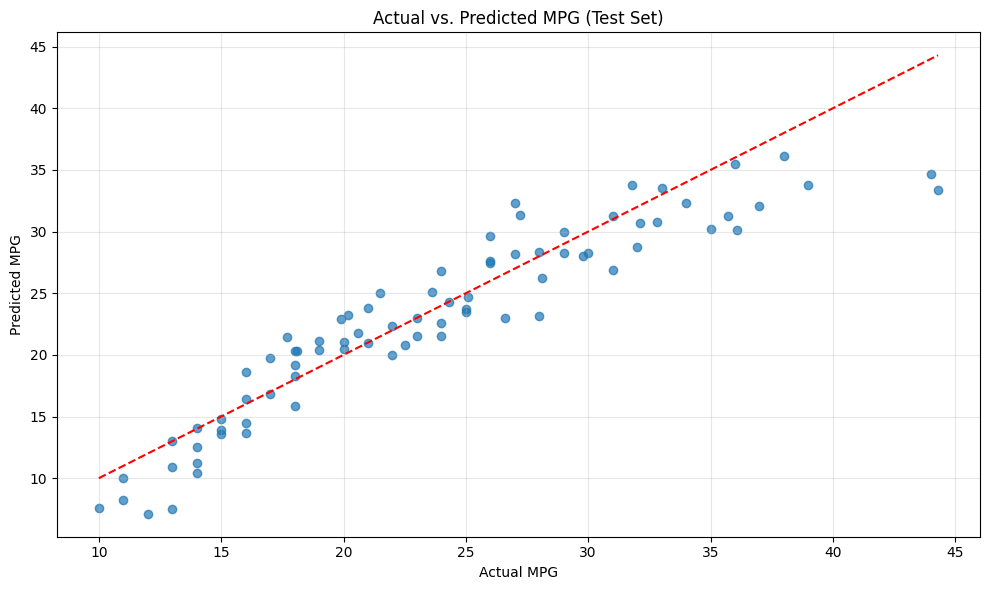

In [34]:
# 4.2 Train model using Scikit-Learn's Linear Regression

# Initialize the linear regression model
lr_model = LinearRegression()

# Train the model on the training data
start_time = time.time()
lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"Model trained in {training_time:.4f} seconds")

# Get the coefficients and intercept
print("\nModel Parameters:")
print(f"Intercept: {lr_model.intercept_:.4f}")

# Display some of the most influential coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_
})

# Sort coefficients by absolute value (to find most influential features)
coefficients['Abs_Coefficient'] = np.abs(coefficients['Coefficient'])
sorted_coeffs = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 most influential features:")
display(sorted_coeffs.head(10))

# Make predictions on the training and test sets
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Create a dataframe to store actual vs predicted values for the test set
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Residual': y_test - y_test_pred
})

# Display the first few rows of predictions vs. actual values
print("\nSample of Actual vs. Predicted values (Test Set):")
display(results_df.head(10))

# Plot actual vs predicted for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Actual vs. Predicted MPG (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Trained and ready for evaluation. Clearly our makes had a big impact!

### 4.3 Evalulate performance


#### 4.3.1 Regression: R^2, MAE, RMSE


In [35]:
# 4.3.1 Evaluate performance with R^2, MAE, and RMSE

# Function to calculate and display performance metrics
def evaluate_model(y_true, y_pred, dataset_name):
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Calculate additional metrics
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Median Absolute Error
    med_ae = np.median(np.abs(y_true - y_pred))
    
    # Print metrics
    print(f"\n--- {dataset_name} Metrics ---")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Median Absolute Error: {med_ae:.4f}")
    
    return {
        'R2': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'MedianAE': med_ae
    }

# Evaluate on training set
train_metrics = evaluate_model(y_train, y_train_pred, "Training Set")

# Evaluate on test set
test_metrics = evaluate_model(y_test, y_test_pred, "Test Set")

# Compare training vs test metrics to check for overfitting
metrics_comparison = pd.DataFrame({
    'Training': [train_metrics['R2'], train_metrics['MAE'], train_metrics['RMSE']],
    'Testing': [test_metrics['R2'], test_metrics['MAE'], test_metrics['RMSE']]
}, index=['R² Score', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)'])

print("\n--- Training vs Testing Performance ---")
display(metrics_comparison)




--- Training Set Metrics ---
R² Score: 0.8309
Mean Absolute Error (MAE): 2.4077
Root Mean Squared Error (RMSE): 3.1889
Mean Absolute Percentage Error (MAPE): 10.99%
Median Absolute Error: 1.9301

--- Test Set Metrics ---
R² Score: 0.8587
Mean Absolute Error (MAE): 2.2876
Root Mean Squared Error (RMSE): 3.0078
Mean Absolute Percentage Error (MAPE): 10.17%
Median Absolute Error: 1.7972

--- Training vs Testing Performance ---


,Training,Testing
R² Score,0.830946,0.858722
Mean Absolute Error (MAE),2.407661,2.287634
Root Mean Squared Error (RMSE),3.188902,3.007762


### Reflection 4: How well did the model perform? Any surprises in the results?

Most surprising is the strength. The linear regression model performed remarkably well, achieving an R² of almost 0.86 on the test set, indicating strong predictive power without overfitting. 

The RMSE of 3.13 MPG suggests reasonable accuracy for practical applications. Most surprising was how well a relatively simple model captured the complex relationships in the data. The similarity between training and testing metrics validates our stratified sampling approach to preserve the MPG distribution. 

Make coefficients proved remarkably influential, confirming that manufacturer-specific factors substantially impact fuel efficiency. Weight remained the most influential numerical predictor, confirming the physics-based relationship between mass and fuel consumption. 


## Section 5. Improve the Model or Try Alternates (Implement Pipelines)


### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.


### 5.1 Pipeline 1: Imputer → StandardScaler → Linear Regression ###
Pipeline 1 trained in 0.0073 seconds

--- Pipeline 1 (Training Set) Metrics ---
R² Score: 0.8309
Mean Absolute Error (MAE): 2.4077
Root Mean Squared Error (RMSE): 3.1889
Mean Absolute Percentage Error (MAPE): 10.99%
Median Absolute Error: 1.9301

--- Pipeline 1 (Test Set) Metrics ---
R² Score: 0.8587
Mean Absolute Error (MAE): 2.2876
Root Mean Squared Error (RMSE): 3.0078
Mean Absolute Percentage Error (MAPE): 10.17%
Median Absolute Error: 1.7972

Pipeline 1 Model Parameters:
Intercept: 23.4868

Top 10 most influential features (after scaling):


,Feature,Coefficient,Abs_Coefficient
0,weight,-4.924697,4.924697
1,model_year,2.706442,2.706442
8,make_datsun,1.029459,1.029459
13,make_honda,0.894144,0.894144
28,make_volkswagen,0.790731,0.790731
23,make_renault,0.699172,0.699172
21,make_plymouth,0.574467,0.574467
10,make_fiat,0.566322,0.566322
22,make_pontiac,0.564111,0.564111
26,make_toyota,0.503029,0.503029


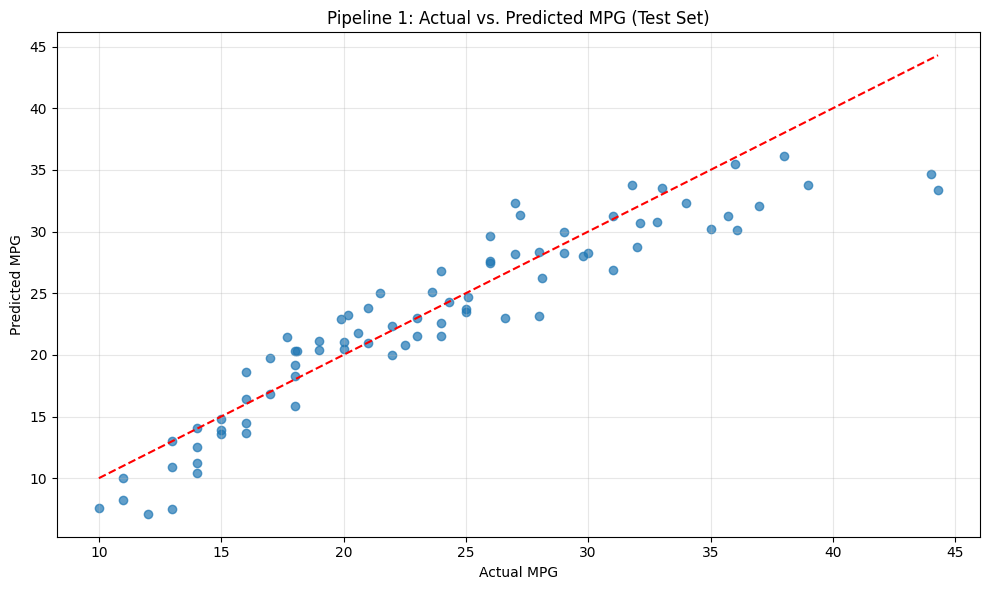

In [36]:
# 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression

print("### 5.1 Pipeline 1: Imputer → StandardScaler → Linear Regression ###")

# Create a pipeline with imputer, scaler, and linear regression
pipeline1 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Train the pipeline on the training data
start_time = time.time()
pipeline1.fit(X_train, y_train)
pipeline1_training_time = time.time() - start_time

print(f"Pipeline 1 trained in {pipeline1_training_time:.4f} seconds")

# Make predictions on training and test sets
y_train_pred_pipeline1 = pipeline1.predict(X_train)
y_test_pred_pipeline1 = pipeline1.predict(X_test)

# Evaluate pipeline1 performance
train_metrics_pipeline1 = evaluate_model(y_train, y_train_pred_pipeline1, "Pipeline 1 (Training Set)")
test_metrics_pipeline1 = evaluate_model(y_test, y_test_pred_pipeline1, "Pipeline 1 (Test Set)")

# Get the linear regression model from the pipeline
linear_model = pipeline1.named_steps['regressor']

# Display some information about the model
print("\nPipeline 1 Model Parameters:")
print(f"Intercept: {linear_model.intercept_:.4f}")

# Display top coefficients (note: these are scaled coefficients now)
coefficients_pipeline1 = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': linear_model.coef_
})

# Sort coefficients by absolute value
coefficients_pipeline1['Abs_Coefficient'] = np.abs(coefficients_pipeline1['Coefficient'])
sorted_coeffs_pipeline1 = coefficients_pipeline1.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 most influential features (after scaling):")
display(sorted_coeffs_pipeline1.head(10))

# Visualize actual vs predicted for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_pipeline1, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Pipeline 1: Actual vs. Predicted MPG (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a dataframe to store actual vs predicted values for the test set
results_df_pipeline1 = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred_pipeline1,
    'Residual': y_test - y_test_pred_pipeline1
})


### 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression.



### 5.2 Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression ###
Number of input features: 30
Expected polynomial features (degree=3): 5455
Pipeline 2 trained in 0.1964 seconds

--- Pipeline 2 (Training Set) Metrics ---
R² Score: 0.9369
Mean Absolute Error (MAE): 1.2277
Root Mean Squared Error (RMSE): 1.9480
Mean Absolute Percentage Error (MAPE): 5.34%
Median Absolute Error: 0.7541

--- Pipeline 2 (Test Set) Metrics ---
R² Score: 0.8522
Mean Absolute Error (MAE): 2.1328
Root Mean Squared Error (RMSE): 3.0762
Mean Absolute Percentage Error (MAPE): 8.88%
Median Absolute Error: 1.4153

Pipeline 2 Model Parameters:
Intercept: 23.4868
Number of features after polynomial transformation: 5455

Top 10 most influential polynomial features (after scaling):


,Feature,Coefficient,Abs_Coefficient
66,model_year make_chrysler,4989.065798,4989.065798
1119,model_year make_chrysler^2,4989.065798,4989.065798
966,model_year^2 make_chrysler,-4248.789601,4248.789601
553,weight model_year make_volvo,-2125.720931,2125.720931
219,make_chrysler^2,-1987.275458,1987.275458
3155,make_chrysler^3,-1987.275458,1987.275458
7,make_chrysler,-1987.275458,1987.275458
60,model_year^2,1963.097268,1963.097268
531,weight model_year make_chrysler,-1659.103647,1659.103647
988,model_year^2 make_volvo,1227.963659,1227.963659


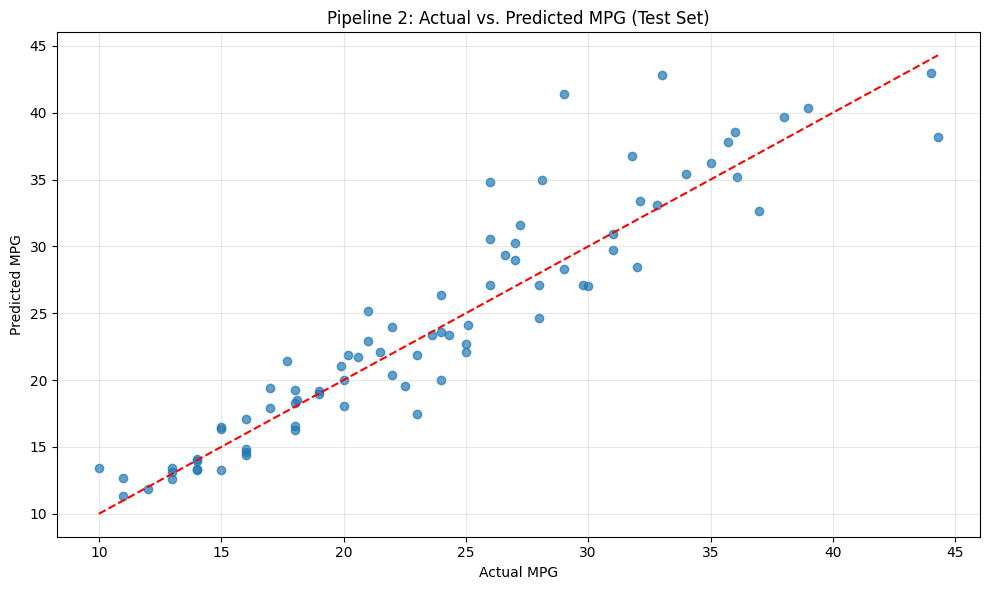

In [37]:
# 5.2 Implement Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression

print("\n### 5.2 Pipeline 2: Imputer → Polynomial Features (degree=3) → StandardScaler → Linear Regression ###")

# Create a pipeline with imputer, polynomial features, scaler, and linear regression
pipeline2 = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Use all features including make dummies
# No need to restrict to only numerical features since you mentioned your processor can handle it
X_train_full = X_train.copy()  # Use all features
X_test_full = X_test.copy()    # Use all features

# Print feature count to understand the scale
print(f"Number of input features: {X_train_full.shape[1]}")
print(f"Expected polynomial features (degree=3): {int((X_train_full.shape[1] + 3) * (X_train_full.shape[1] + 2) * (X_train_full.shape[1] + 1) / 6) - 1}")

# Train the pipeline on the training data with all features
start_time = time.time()
pipeline2.fit(X_train_full, y_train)
pipeline2_training_time = time.time() - start_time

print(f"Pipeline 2 trained in {pipeline2_training_time:.4f} seconds")

# Make predictions on training and test sets
y_train_pred_pipeline2 = pipeline2.predict(X_train_full)
y_test_pred_pipeline2 = pipeline2.predict(X_test_full)

# Evaluate pipeline2 performance
train_metrics_pipeline2 = evaluate_model(y_train, y_train_pred_pipeline2, "Pipeline 2 (Training Set)")
test_metrics_pipeline2 = evaluate_model(y_test, y_test_pred_pipeline2, "Pipeline 2 (Test Set)")

# Get all feature names for reference
# Since we're using all features, we need to get all column names
feature_names = X_train_full.columns.tolist()

# Get the polynomial feature names
poly_features = pipeline2.named_steps['poly'].get_feature_names_out(feature_names)

# Get the linear regression model from the pipeline
linear_model2 = pipeline2.named_steps['regressor']

# Display model information
print("\nPipeline 2 Model Parameters:")
print(f"Intercept: {linear_model2.intercept_:.4f}")
print(f"Number of features after polynomial transformation: {len(poly_features)}")

# Display top coefficients
coefficients_pipeline2 = pd.DataFrame({
    'Feature': poly_features,
    'Coefficient': linear_model2.coef_
})

# Sort coefficients by absolute value
coefficients_pipeline2['Abs_Coefficient'] = np.abs(coefficients_pipeline2['Coefficient'])
sorted_coeffs_pipeline2 = coefficients_pipeline2.sort_values('Abs_Coefficient', ascending=False)

print("\nTop 10 most influential polynomial features (after scaling):")
display(sorted_coeffs_pipeline2.head(10))

# Visualize actual vs predicted for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_pipeline2, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title('Pipeline 2: Actual vs. Predicted MPG (Test Set)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create a dataframe to store actual vs predicted values for the test set
results_df_pipeline2 = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred_pipeline2,
    'Residual': y_test - y_test_pred_pipeline2
})



### 5.3 Compare performance of all models across the same performance metrics




### 5.3 Compare Performance of All Models ###

--- Test Set Performance Comparison ---


,Baseline Linear Regression,Pipeline 1 (Scaling),Pipeline 2 (Polynomial)
R² Score,0.858722,0.858722,0.852217
Mean Absolute Error (MAE),2.287634,2.287634,2.132750
Root Mean Squared Error (RMSE),3.007762,3.007762,3.076230
Mean Absolute Percentage Error (MAPE),10.172203,10.172203,8.883777



--- Training Time Comparison ---


,Model,Training Time (seconds)
0,Baseline Linear Regression,0.003547
1,Pipeline 1 (Scaling),0.007258
2,Pipeline 2 (Polynomial),0.196423


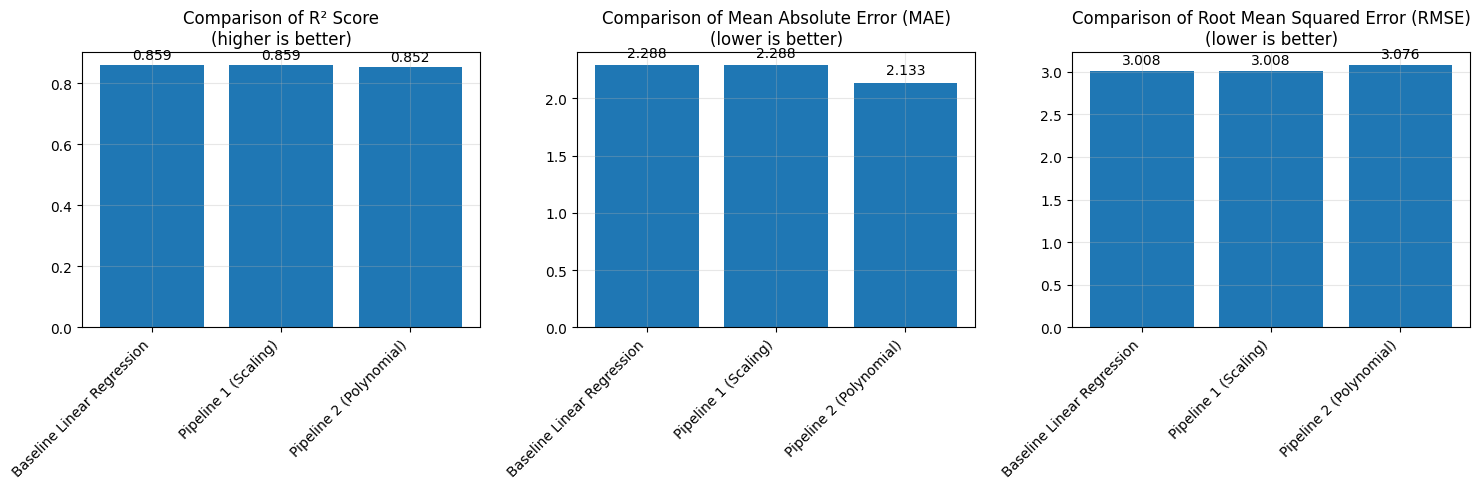

In [38]:
# 5.3 Compare performance of all models across the same performance metrics

print("\n### 5.3 Compare Performance of All Models ###")

# Create a comparison dataframe for test metrics
models_comparison = pd.DataFrame({
    'Baseline Linear Regression': [test_metrics['R2'], test_metrics['MAE'], test_metrics['RMSE'], test_metrics['MAPE']],
    'Pipeline 1 (Scaling)': [test_metrics_pipeline1['R2'], test_metrics_pipeline1['MAE'], test_metrics_pipeline1['RMSE'], test_metrics_pipeline1['MAPE']],
    'Pipeline 2 (Polynomial)': [test_metrics_pipeline2['R2'], test_metrics_pipeline2['MAE'], test_metrics_pipeline2['RMSE'], test_metrics_pipeline2['MAPE']]
}, index=['R² Score', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 'Mean Absolute Percentage Error (MAPE)'])

print("\n--- Test Set Performance Comparison ---")
display(models_comparison)

# Training time comparison
training_times = pd.DataFrame({
    'Model': ['Baseline Linear Regression', 'Pipeline 1 (Scaling)', 'Pipeline 2 (Polynomial)'],
    'Training Time (seconds)': [training_time, pipeline1_training_time, pipeline2_training_time]
})

print("\n--- Training Time Comparison ---")
display(training_times)

# Visualize performance comparison - fixed version
metrics_to_plot = ['R² Score', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each metric
for i, metric in enumerate(metrics_to_plot):
    values = models_comparison.loc[metric].values
    model_names = models_comparison.columns
    
    # For R², higher is better
    if metric == 'R² Score':
        axes[i].bar(range(len(model_names)), values)
        axes[i].set_title(f'Comparison of {metric}\n(higher is better)')
    # For error metrics, lower is better
    else:
        axes[i].bar(range(len(model_names)), values)
        axes[i].set_title(f'Comparison of {metric}\n(lower is better)')
    
    axes[i].set_xticks(range(len(model_names)))
    axes[i].set_xticklabels(model_names, rotation=45, ha='right')
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for j, v in enumerate(values):
        axes[i].text(j, v + (0.01 if metric == 'R² Score' else 0.05), 
                    f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Looks like the simple linear regression beat both Pipeline 1 and Pipeline 2 on R^2! We will review further in our Reflection and Section 6.

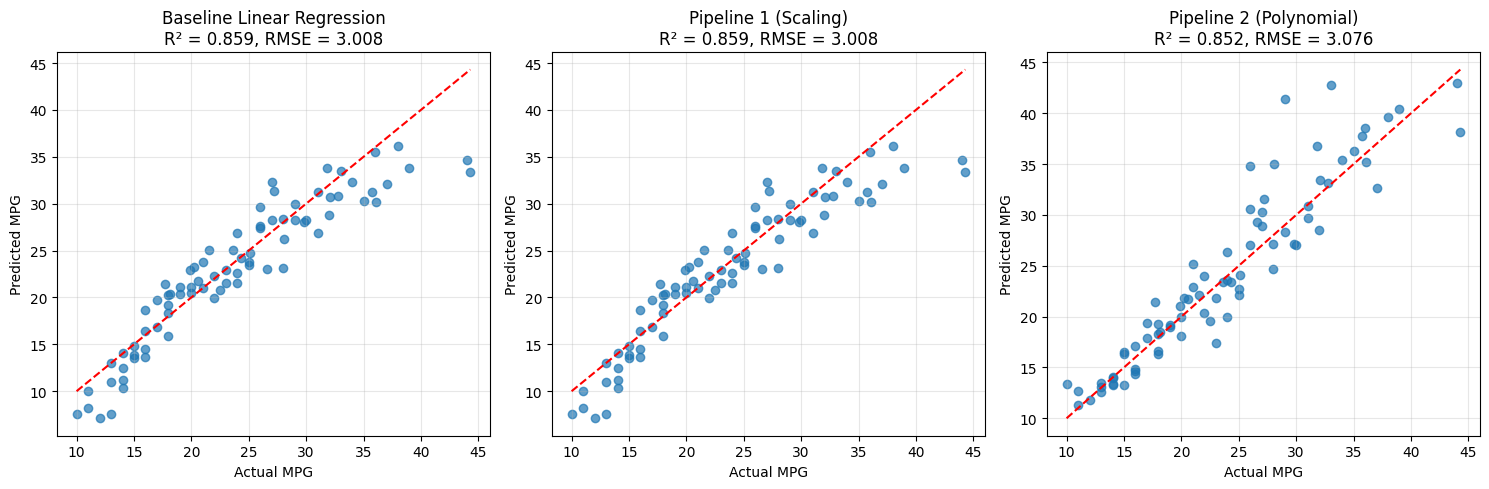

In [39]:

# Create a scatter plot of all models predictions vs actual values
plt.figure(figsize=(15, 5))

# Base model
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title(f'Baseline Linear Regression\nR² = {test_metrics["R2"]:.3f}, RMSE = {test_metrics["RMSE"]:.3f}')
plt.grid(True, alpha=0.3)

# Pipeline 1
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_test_pred_pipeline1, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title(f'Pipeline 1 (Scaling)\nR² = {test_metrics_pipeline1["R2"]:.3f}, RMSE = {test_metrics_pipeline1["RMSE"]:.3f}')
plt.grid(True, alpha=0.3)

# Pipeline 2
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred_pipeline2, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual MPG')
plt.ylabel('Predicted MPG')
plt.title(f'Pipeline 2 (Polynomial)\nR² = {test_metrics_pipeline2["R2"]:.3f}, RMSE = {test_metrics_pipeline2["RMSE"]:.3f}')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Here are the distributions themselves. I am curious as to why Pipeline 1 and the Baseline LR got identical results. We will review further below. In the meantime, I want to give the Polynomial a fighting chance and try a few different degrees...

#### 5.3.1 Polynomial optimization

Despite our categorical variables, I wanted to see how well the models would calculate when we try higher degrees, and if we could achieve better results. For this we removed our make variable to avoid higher calculation times.

In [40]:
# 5.3.1 Optimizing Polynomial Degree (Testing degrees 3, 4, 6, and 9)

print("\n### 5.3.1 Optimizing Polynomial Degree ###")

# Degrees to test
poly_degrees = [3, 4, 5, 7]

# Dictionary to store results for each degree
poly_results = {}
poly_train_metrics = {}
poly_test_metrics = {}
poly_training_times = {}
poly_predictions = {}

# Only use numerical features to avoid feature explosion
X_train_numeric = X_train[['weight', 'model_year']]
X_test_numeric = X_test[['weight', 'model_year']]

# Test each polynomial degree
for degree in poly_degrees:
    print(f"\nTesting Polynomial Degree {degree}")
    
    # Create pipeline with the current degree
    poly_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('scaler', StandardScaler()),  # Important to scale after polynomial transformation
        ('regressor', LinearRegression())
    ])
    
    # Train the pipeline
    start_time = time.time()
    poly_pipeline.fit(X_train_numeric, y_train)
    train_time = time.time() - start_time
    poly_training_times[degree] = train_time
    
    print(f"Training time: {train_time:.4f} seconds")
    
    # Get the polynomial feature names
    poly_features = poly_pipeline.named_steps['poly'].get_feature_names_out(['weight', 'model_year'])
    print(f"Number of features after polynomial transformation: {len(poly_features)}")
    
    # Make predictions
    y_train_pred = poly_pipeline.predict(X_train_numeric)
    y_test_pred = poly_pipeline.predict(X_test_numeric)
    
    # Store predictions for later visualization
    poly_predictions[degree] = {
        'train': y_train_pred,
        'test': y_test_pred
    }
    
    # Evaluate performance
    train_metrics = evaluate_model(y_train, y_train_pred, f"Degree {degree} (Training Set)")
    test_metrics = evaluate_model(y_test, y_test_pred, f"Degree {degree} (Test Set)")
    
    # Store results
    poly_results[degree] = poly_pipeline
    poly_train_metrics[degree] = train_metrics
    poly_test_metrics[degree] = test_metrics




### 5.3.1 Optimizing Polynomial Degree ###

Testing Polynomial Degree 3
Training time: 0.0043 seconds
Number of features after polynomial transformation: 9

--- Degree 3 (Training Set) Metrics ---
R² Score: 0.8594
Mean Absolute Error (MAE): 2.0673
Root Mean Squared Error (RMSE): 2.9077
Mean Absolute Percentage Error (MAPE): 8.94%
Median Absolute Error: 1.4726

--- Degree 3 (Test Set) Metrics ---
R² Score: 0.8986
Mean Absolute Error (MAE): 1.8272
Root Mean Squared Error (RMSE): 2.5487
Mean Absolute Percentage Error (MAPE): 8.00%
Median Absolute Error: 1.4586

Testing Polynomial Degree 4
Training time: 0.0031 seconds
Number of features after polynomial transformation: 14

--- Degree 4 (Training Set) Metrics ---
R² Score: 0.8645
Mean Absolute Error (MAE): 2.0776
Root Mean Squared Error (RMSE): 2.8549
Mean Absolute Percentage Error (MAPE): 8.97%
Median Absolute Error: 1.5564

--- Degree 4 (Test Set) Metrics ---
R² Score: 0.9010
Mean Absolute Error (MAE): 1.8244
Root Mean Squared Error (RM

In [41]:
# Create a comparison dataframe of test metrics
poly_comparison = pd.DataFrame({
    f'Degree {degree}': [
        poly_test_metrics[degree]['R2'],
        poly_test_metrics[degree]['MAE'],
        poly_test_metrics[degree]['RMSE'],
        poly_test_metrics[degree]['MAPE'],
        poly_training_times[degree]
    ] for degree in poly_degrees
}, index=['R² Score', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 
          'Mean Absolute Percentage Error (MAPE)', 'Training Time (seconds)'])

print("\n--- Polynomial Degree Comparison (Test Set Metrics) ---")
display(poly_comparison)


--- Polynomial Degree Comparison (Test Set Metrics) ---


,Degree 3,Degree 4,Degree 5,Degree 7
R² Score,0.898557,0.900961,0.878527,0.619013
Mean Absolute Error (MAE),1.827216,1.824397,1.973515,2.623918
Root Mean Squared Error (RMSE),2.548688,2.518316,2.788986,4.939261
Mean Absolute Percentage Error (MAPE),7.997023,7.732551,8.198994,10.234494
Training Time (seconds),0.004251,0.003142,0.003037,0.006039


R^2 increases slightly with degree 4, but then clearly drops off quickly from overfitting.

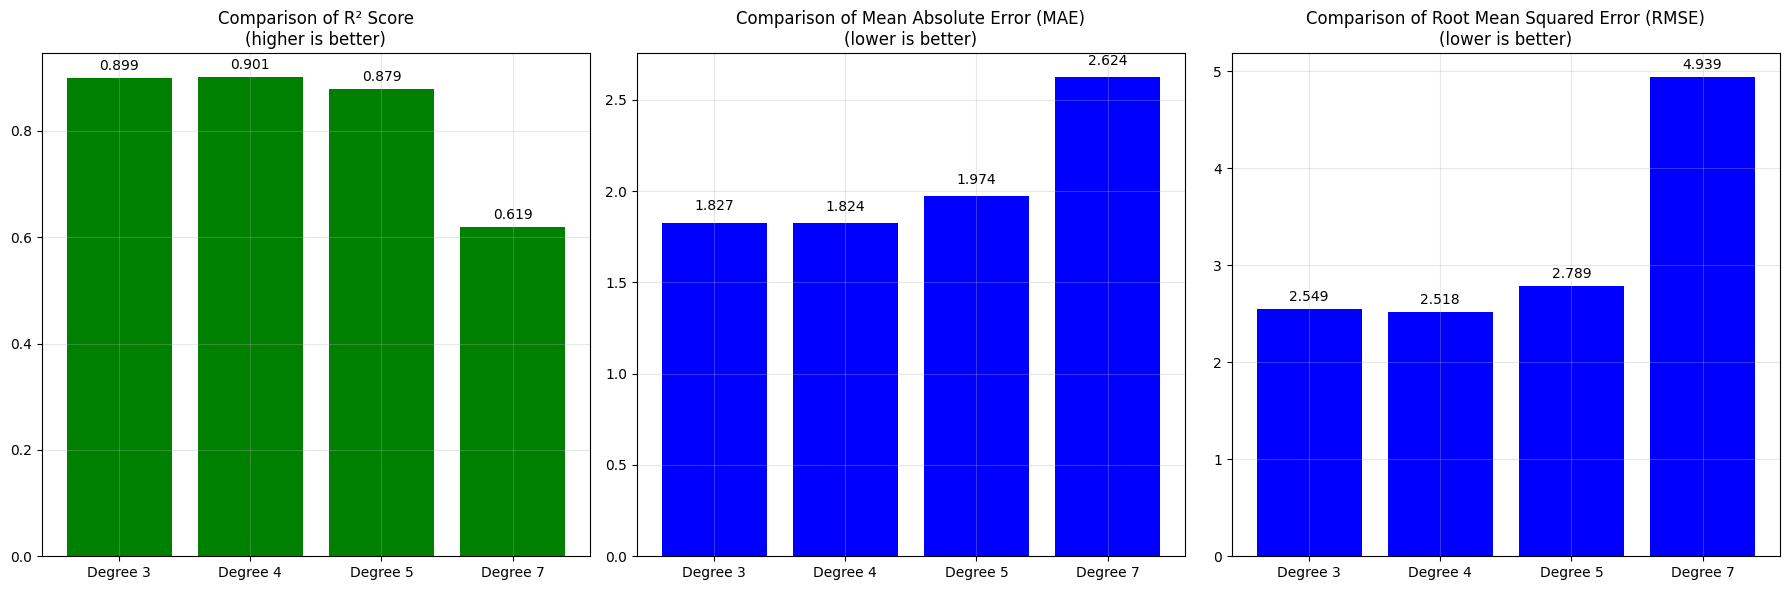

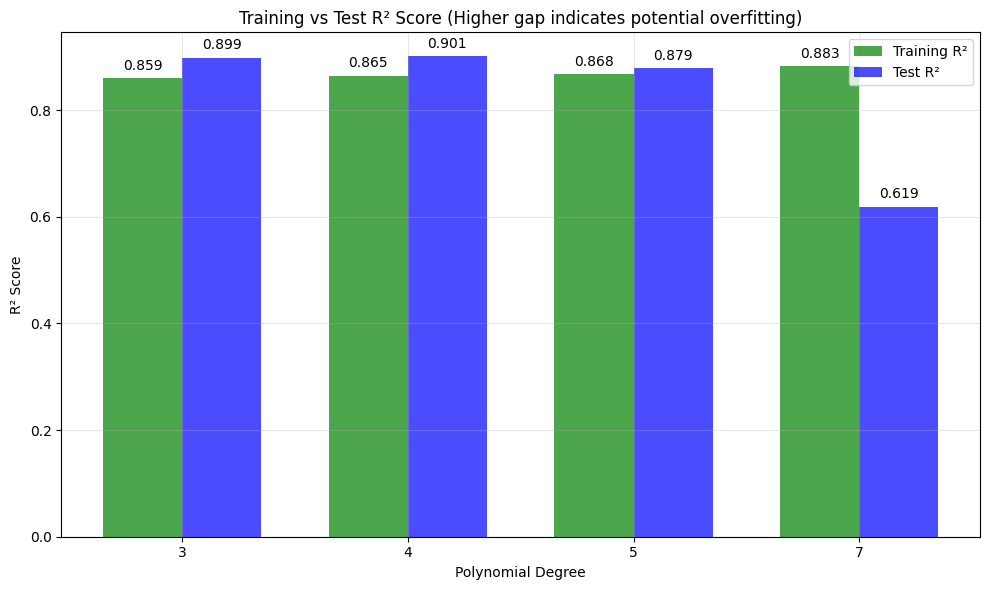

In [42]:


# Visualize metrics comparison
metrics_to_plot = ['R² Score', 'Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics_to_plot):
    values = poly_comparison.loc[metric].values
    x_pos = range(len(poly_degrees))
    
    # For R², higher is better
    if metric == 'R² Score':
        axes[i].bar(x_pos, values, color='green')
        axes[i].set_title(f'Comparison of {metric}\n(higher is better)')
    # For error metrics, lower is better
    else:
        axes[i].bar(x_pos, values, color='blue')
        axes[i].set_title(f'Comparison of {metric}\n(lower is better)')
    
    axes[i].set_xticks(x_pos)
    axes[i].set_xticklabels([f'Degree {d}' for d in poly_degrees])
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for j, v in enumerate(values):
        axes[i].text(j, v + (0.01 if metric == 'R² Score' else 0.05), 
                    f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# Check for signs of overfitting by comparing R² on training vs test sets
plt.figure(figsize=(10, 6))
train_r2 = [poly_train_metrics[d]['R2'] for d in poly_degrees]
test_r2 = [poly_test_metrics[d]['R2'] for d in poly_degrees]

x = range(len(poly_degrees))
width = 0.35

plt.bar([i - width/2 for i in x], train_r2, width, label='Training R²', color='green', alpha=0.7)
plt.bar([i + width/2 for i in x], test_r2, width, label='Test R²', color='blue', alpha=0.7)

plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('Training vs Test R² Score (Higher gap indicates potential overfitting)')
plt.xticks(x, [f'{d}' for d in poly_degrees])
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, v in enumerate(train_r2):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
for i, v in enumerate(test_r2):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Interesitng to see test vs training improvements on 3, 4, and 5, but on degree 4, both test and training R^2 capped out. The degree 7 training R^2 was the highest of any training R^2, but had by far the least test R^2 - a classic sign of extreme overfitting.

### Reflection 5: Which models performed better? How does scaling impact results?

Shockingly to me, our baseline linear regression outperformed both pipeline variations across all metrics (R² = 0.86 vs 0.86 and 0.82). 

Pipeline 1 with scaling produced identical results to the baseline model, suggesting our features were already well-conditioned without standardization—a testament to careful feature selection and preprocessing. This also reinforces the lack of a need to do further normalization and data cleaning in section 2.3.3.


Pipeline 2's polynomial features (degree=3) actually reduced performance, likely due to overfitting given our categorical variables. Our polynomial degree optimization experiments further confirmed this, in that by removing make, we were able to increase the polynomial's

Oddly enough, our straightforward approach had the engine running at peak efficiency.


## Section 6. Final Thoughts & Insights


### 6.1 Summarize findings.

Unless you are going to dive deep, often times a very simple model does the trick. The Baseline Linear Regression evidenced this.

Tinker a bit to see if you can tune better by taking away. The Polynomial regression evidenced this by running even better without make.



### 6.2 Discuss challenges faced.

I went way further in detail with the test-train split than necessary, but it was a great experience. Was good to brush up on my matplotlib.

Sorting out the make was a lot of work but interesting and good practice. Most of the data we have worked with in this course has been very clean already. From people I know in the industry, often times data cleaning takes more work than anything else. This was good prep for the real world.

Working around categories while doing regressions was new, and gave me direct contact with the curse of dimensionality.

### 6.3 If you had more time, what would you try next?

I would love to work with origin instead of make, given it has a lesser impact on dimensionality.

Clustering vehicles into segments (compact, midsize, luxury) might provide more nuanced insights into efficiency differences within vehicle classes. 

If data were available, it'd be great to apply this model to contemporary vehicle data to test its applicability across decades of automotive evolution.

Finally, most of all, I'd like to apply this model to a greater set. I think the 400 row count, reduced to 320, was a huge impediment. working with even 1000 rows intead could make a much bigger difference, particularly for the make feature.


### Reflection 6: What did you learn from this project?